In [1]:
!which python; python --version; pwd

/mnt/qb/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15
/mnt/qb/work/macke/mwe102/sourcerer-sequential/notebooks


In [2]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from corner import corner
from matplotlib import pyplot as plt

# hodgkin-huxley
from sourcerer.utils import scale_tensor
from sourcerer.hh_simulator import EphysModel # hh simulator
from sourcerer.hh_utils import HHSurro, PRIOR_MAX, PRIOR_MIN, DEF_RESTRICTED

from sourcerer.fit_surrogate import (
    create_train_val_dataloaders,
    fit_conditional_normalizing_flow,
    train_val_split,
    create_dataloader
)
from sourcerer.real_nvp import (
    Sampler,
    RealNVPs,
    TemperedUniform, # a little slanted uniform to make log-density well defined
    VariableTemperedUniform,
    kozachenko_leonenko_estimator,
)

from sourcerer.sbi_classifier_two_sample_test import c2st_scores

# other simulators
from sourcerer.simulators import (
    InverseKinematicsSimulator,
    LotkaVolterraSimulator,
    SIRSimulator,
    SLCPSimulator,
    TwoMoonsSimulator,
    GaussianMixtureSimulator,
)

# wasserstein source
from sourcerer.sliced_wasserstein import sliced_wasserstein_distance
from sourcerer.wasserstein_estimator import train_source

# saving utils
from sourcerer.utils import (
    save_cfg_as_yaml,
    save_fig,
    save_numpy_csv,
    save_state_dict,
    script_or_command_line_cfg,
    set_seed,
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'run id: {run_id}')
print(f"using {device}")

run id: 20250113_143241
using cuda


In [4]:
0.00001 == 1e-5, 0.0005 == 5e-4

(True, True)

In [5]:
# Define config
# NOTE: These overrides only take effect if this script is run interactively
local_overrides = [
    "base.tag=debug",
    "base.folder=sequential_hh",
    "source=wasserstein_hh",
    "source.fin_lambda=0.25",
    "surrogate=hh_train_surrogate", #load_hh_surrogate
    # "surrogate.ydim=5",
    # "surrogate.surrogate_path=./hh_surrogate_epochs_100.pt",
]

cfg = script_or_command_line_cfg(
    config_name="config",
    config_path="../conf",
    local_overrides=local_overrides,
    name=__name__,
)

assert cfg.base.tag is not None
assert cfg.base.folder is not None

print(OC.to_yaml(cfg))

save_cfg_as_yaml(
    cfg,
    f"{cfg.base.tag}_cfg.yaml",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

base:
  tag: debug
  folder: sequential_hh
  base_path: ./results_sourcerer
  seed: null
simulator:
  self: inverse_kinematics
  box_domain_lower: -3.141592653589
  box_domain_upper: 3.141592653589
surrogate:
  self: hh_train_surrogate
  num_training_samples: 1000000
  xdim: 13
  ydim: 5
  num_hidden_layers: 4
  hidden_layer_dim: 256
  nb_epochs: 250
  surrogate_lr: 0.0005
  surrogate_weight_decay: 1.0e-05
  early_stopping_patience: 50
source_model:
  self: sampler
  num_hidden_layers: 3
  hidden_layer_dim: 100
source:
  self: wasserstein_hh
  xo_path: TODO_path_to_observations.pkl
  wasserstein_slices: 500
  wasserstein_order: 2
  use_log_sw: true
  num_chunks: 1
  num_kole_samples: 512
  pretraining_steps: 2000
  linear_decay_steps: 2000
  lambda_steps: 11000
  fin_lambda: 0.25
  learning_rate: 0.0001
  weight_decay: 1.0e-05
  early_stopping_patience: 1000000
sequential:
  self: naive
  total_simulation_budget: 2000
  number_of_iterations: 2
  subsampling: false
  collate_last_iter_d

In [6]:
# set seed
if cfg.base.seed is None:
    random_random_seed = np.random.randint(2**16)
    set_seed(random_random_seed)
    save_numpy_csv(
        np.array([random_random_seed], dtype=int),
        file_name=f"{cfg.base.tag}_seed.csv",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    print(f"seed: {random_random_seed}")
else:
    set_seed(cfg.base.seed)

seed: 33891


In [7]:
cfg.surrogate

{'self': 'hh_train_surrogate', 'num_training_samples': 1000000, 'xdim': 13, 'ydim': 5, 'num_hidden_layers': 4, 'hidden_layer_dim': 256, 'nb_epochs': 250, 'surrogate_lr': 0.0005, 'surrogate_weight_decay': 1e-05, 'early_stopping_patience': 50}

In [8]:
# notation here: θ (which is x here), and x (which is x here) 
print(f"theta/parameter dimension: {cfg.surrogate.xdim}")
print(f"x/observation dimension: {cfg.surrogate.ydim}")
theta_labels = [fr"$\theta_{i+1}$" for i in range(cfg.surrogate.xdim)]
y_labels = [fr"$x_{i+1}$" for i in range(cfg.surrogate.ydim)]

theta/parameter dimension: 13
x/observation dimension: 5


## initialize surrogate and its optimizer

In [9]:
# Define surrogate model
surrogate = HHSurro(hidden_layer_dim=cfg.surrogate.hidden_layer_dim,
                    xdim=cfg.surrogate.xdim,
                    ydim=cfg.surrogate.ydim
                   ).to(device)

surro_optimizer = optim.Adam(surrogate.parameters(),
                             lr=cfg.surrogate.surrogate_lr, # 5e-4
                             weight_decay=cfg.surrogate.surrogate_weight_decay # 1e-5
                            )

assert cfg.surrogate.self == 'hh_train_surrogate'

In [10]:
# 14999995/10**6

## load data
note: here we are not using the simulator (also hh simulator takes a fairly long-ish time!), but instead using already generated data

## purpose of the data
- so data has $\approx$ 15M `theta` and `x` pairs already simulated from the HH simulator
- when doing the sequential method, we update our HHsurrogate at each iteration, then sample `theta`s from the source at that point, and call the simulator on it to get the corresponding `x`s and hence prepare the training data to update the surrogate for the next round
- but the HH simulator takes a long time!!

## some data loading utils to be used later on...

In [11]:
supervised_mean = torch.tensor(
    [  # correct restricted 1 mil
        2.3512,
        -93.2657,
        -52.7358,
        278.4319,
        0.4392,
    ],
)

supervised_std = torch.tensor(
    [  # correct restricted 1 mil
        1.1922,
        20.0920,
        19.6483,
        300.1352,
        4.4579,
    ],
)

def fetch_hh_data_full(path='./full_batch.npz'):
    sim_data = np.load(path)
    theta = sim_data["theta"]
    stats = sim_data["stats"]

    # Remove undefined simulations (either only the 5 out of 15mil that completelly fail, or the ones without undefined stats)
    keeping = (~np.isnan(np.mean(stats, axis=1))) & (~np.isinf(np.mean(stats, axis=1)))
    moment_keeping = (~np.isnan(stats[:, 22])) & (~np.isinf(stats[:, 22]))  # 22 is a moment
    #print(theta[~moment_keeping, :])  # 5 sims out of 15mil completely fail
    # print(np.where(moment_keeping == 0)[0])

    stats = stats[moment_keeping, :]  # delete Nan simulations that completely fail
    theta = theta[moment_keeping, :]  # delete Nan simulations that completely fail
    
    stats = stats[:, DEF_RESTRICTED]
    # reverse engineer unnecessarily undefined counts -- why??
    stats[:, :1][np.isnan(stats[:, :1])] = np.log(3)

    # standardization
    source_dim = 13
    # standardize source to range from -1 to 1
    source = scale_tensor(
        torch.from_numpy(np.float32(theta)),
        PRIOR_MIN,               # current range
        PRIOR_MAX,
        -torch.ones(source_dim), # target range
        torch.ones(source_dim),
    )
    
    stats_torch = torch.from_numpy(np.float32(stats))
    stats_mean = torch.mean(stats_torch, dim=0)
    stats_std = torch.std(stats_torch, dim=0)
    # print(stats_mean)
    # print(stats_std)
    stats_torch = (stats_torch - stats_mean) / stats_std
    
    return source, stats_torch # both normalized

## data loading for surrogate training by nearest neighbour search

In [12]:
params, xs = fetch_hh_data_full(path='./full_batch.npz') # note that both params and xs are standardized here
print(params.shape, xs.shape)

torch.Size([14999995, 13]) torch.Size([14999995, 5])


In [13]:
cfg.sequential.total_simulation_budget = 1_000_000 # try with 500k=0.5M
cfg.sequential.number_of_iterations = 3
cfg.sequential

{'self': 'naive', 'total_simulation_budget': 1000000, 'number_of_iterations': 3, 'subsampling': False, 'collate_last_iter_data': True, 'lambda_stays_same': True, 'frontloading': False, 'front_frac': 0.3, 'number_of_sims_source': 250000}

In [14]:
cfg.surrogate.num_training_samples = cfg.sequential.total_simulation_budget

In [15]:
# number_of_sims_surrogate = cfg.surrogate.num_training_samples    # this is the total budget (1_000_000 is too much?)
# source      = params[:number_of_sims_surrogate, :] # source in [-1, 1]
# stats_torch =     xs[:number_of_sims_surrogate, :] # xs mean 0, var 1
# print(number_of_sims_surrogate)#, source.shape, stats_torch.shape)

# print(source.shape)
# print(f'range of params: {source.min().item()} to {source.max().item()}')

In [16]:
# for i in range(stats_torch.shape[1]):
#     plt.hist(stats_torch.numpy()[:, i], bins=100)
#     plt.axvline(
#         np.percentile(stats_torch.numpy()[:, i], 10),
#         color="red",
#         linestyle="--",
#         linewidth=1,
#     )
#     plt.axvline(
#         np.percentile(stats_torch.numpy()[:, i], 90),
#         color="red",
#         linestyle="--",
#         linewidth=1,
#     )
#     plt.show()

## notes
- this is a deterministic MLP surrogate, i.e., it is trained on MSE loss (while other surrogates are true flow based conditional density estimators)
- 

## initialize simulator (might be unused if we decide to use the nearest neighbour approach)

In [17]:
# this however takes unnormalized thetas!
M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=None,
    noise_factor=10,
)

def run_hh_simulator(theta, M1_model):
    """
        simulates the model on parameters `theta`, both theta and x are unnormalized
    """
    simu_box_pf = M1_model.simulation_wrapper(theta) # here we need to pass unnormalized source!!!
    simu_box_pf_np = simu_box_pf.numpy()
    strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
    def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]
    def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
    # print(np.sum(def_keeping_box))
    def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
    
    simu_estimated_pf = def_stats_box_np
    
    def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1)) # count of non-nan elements
    # print(np.sum(def_keeping_box))
    return torch.from_numpy(np.float32(simu_estimated_pf)) # again returns non-standardized x-s

In [18]:
cfg.sequential.number_of_sims_source = 500_000
cfg.sequential

{'self': 'naive', 'total_simulation_budget': 1000000, 'number_of_iterations': 3, 'subsampling': False, 'collate_last_iter_data': True, 'lambda_stays_same': True, 'frontloading': False, 'front_frac': 0.3, 'number_of_sims_source': 500000}

## prepare evaluation sets for later use

In [19]:
number_of_sims_source = cfg.sequential.number_of_sims_source # how many x-s to train the source on? It is typically 1M, also it is to be normalized
source_dim = cfg.surrogate.xdim

# choose thetas that are outside of what source model would see (in terms of observations)
# note that here thetas are in [-1, 1], the x-s are standardized
gt_source = params[number_of_sims_source:number_of_sims_source+10_000, :]            # 10k thetas from true source distribution
gt_source_two = params[number_of_sims_source+10_000:number_of_sims_source+20_000, :] # another 10k thetas from true source distribution

# simulations from the dataset (note that these are standardized)
gt_simulator = xs[number_of_sims_source:number_of_sims_source+10_000, :]
gt_simulator_two = xs[number_of_sims_source+10_000:number_of_sims_source+20_000, :]

# we should also use our simulator, first need to move the sources to actual range
gt_source_moved = scale_tensor(gt_source, -torch.ones(source_dim), torch.ones(source_dim), PRIOR_MIN, PRIOR_MAX)
gt_source_two_moved = scale_tensor(gt_source_two, -torch.ones(source_dim), torch.ones(source_dim), PRIOR_MIN, PRIOR_MAX)

gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item() # true source entropy, just compute and save
print(f"Ground truth source entropy estimate: {gt_source_kole}")
save_numpy_csv(
    np.array([gt_source_kole]),
    file_name=f"{cfg.base.tag}_gt_source_kole.csv",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

# print("Sliced wassertein distance on groundtruth y:")
expected_distance = sliced_wasserstein_distance(
    gt_simulator.to(device),     # from theta1
    gt_simulator_two.to(device), # from theta2 (both ground truth)
    num_projections=4096,
    device=device,
).item()


print(f"Sliced wassertein distance on groundtruth y (expected/baseline swd): {expected_distance}, log: {np.log(expected_distance)}")
save_numpy_csv(np.array([expected_distance]),
               file_name=f"{cfg.base.tag}_expected_swd.csv", folder=cfg.base.folder, base_path=cfg.base.base_path)

Ground truth source entropy estimate: 10.892598549641722
Sliced wassertein distance on groundtruth y (expected/baseline swd): 0.03013482503592968, log: -3.502073798072623


In [20]:
gt_simulator_two.device

device(type='cpu')

In [21]:
gt_simulator.mean(0), gt_simulator.std(0)

(tensor([-0.0092, -0.0074, -0.0084,  0.0050, -0.0082]),
 tensor([1.0036, 1.0006, 1.0093, 1.0162, 1.0025]))

## note on normalization:

`source/thetas` are normalized in [-1, 1] range, `x-s` are standardized to have zero mean and unit variance

- for surrogate: we train on normalized source/thetas and standardized x-s
- the M1_model: takes original source, and returns unstandardized x-s
- the source model: is trained on standardized x-s, so it should produced normalized thetas

In [25]:
# we can also get actual simulations (unnormalized) from the thetas using M1_model
gt_simulator_actual = run_hh_simulator(gt_source_moved, M1_model)
gt_simulator_two_actual = run_hh_simulator(gt_source_two_moved, M1_model)
# correct their means
gt_simulator_actual_norm = (gt_simulator_actual - supervised_mean) / supervised_std
gt_simulator_two_actual_norm = (gt_simulator_two_actual - supervised_mean) / supervised_std

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:552: RuntimeWarning: invalid value encountered in log
  np.log(AP_amp_adapt),
 [py.warnings]
  np.log(AP_amp_adapt),

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:552: RuntimeWarning: invalid value encountered in log
  np.log(AP_amp_adapt),
 [py.warnings]
  np.log(AP_amp_adapt),

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:552: RuntimeWarning: invalid value encountered in log
  np.log(AP_amp_adapt),
 [py.warnings]
  np.log(AP_amp_adapt),

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:552: RuntimeWarning: invalid value encountered in log
  np.log(AP_amp_adapt),
 [py.warnings]
  np.log(AP_amp_adapt),

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:552: RuntimeWarning: invalid value encountered in log
  np.log(AP_amp_adapt),
 [py.warnings]
  np.log(AP_amp

In [26]:
gt_simulator_actual.mean(0), gt_simulator_actual.std(0)

(tensor([  2.3695, -93.3932, -52.9221, 279.9305,   0.4755]),
 tensor([  1.1901,  20.0139,  19.5415, 297.0402,   4.4841]))

In [27]:
gt_simulator_two_actual.mean(0), gt_simulator_two_actual.std(0)

(tensor([  2.3412, -93.2558, -52.4389, 280.0923,   0.4334]),
 tensor([  1.1885,  20.1418,  19.7588, 303.5089,   4.4290]))

In [28]:
gt_simulator_actual_norm.mean(0), gt_simulator_actual_norm.std(0)

(tensor([ 0.0153, -0.0063, -0.0095,  0.0050,  0.0081]),
 tensor([0.9982, 0.9961, 0.9946, 0.9897, 1.0059]))

In [29]:
# print("Sliced wassertein distance on groundtruth y:")
expected_distance = sliced_wasserstein_distance(
    gt_simulator_actual_norm.to(device),     # from theta1
    gt_simulator_two_actual_norm.to(device), # from theta2 (both ground truth)
    num_projections=4096,
    device=device,
).item()
print(f"Sliced wassertein distance on groundtruth y (expected/baseline swd): {expected_distance}, log: {np.log(expected_distance)}")

Sliced wassertein distance on groundtruth y (expected/baseline swd): 0.029183881357312202, log: -3.534138730431806


In [30]:
gt_simulator_actual_norm

tensor([[ 1.5671, -1.3448,  0.3096, -0.2460, -0.0415],
        [ 1.6151, -0.2587,  1.5271, -0.4694, -0.1906],
        [-0.6222,  0.2454, -0.4279, -0.7746,  0.7921],
        ...,
        [ 1.2393,  1.4919,  1.3625, -0.5053, -0.0171],
        [ 0.6579,  0.5484,  0.9307,  1.0570, -0.0449],
        [-0.3400, -1.2828, -0.8426,  0.0190,  0.4098]])

In [31]:
gt_simulator

tensor([[ 1.5544, -1.3357,  0.3090, -0.2493, -0.0378],
        [ 1.6147, -0.2495,  1.5256, -0.4716, -0.1840],
        [-0.6225,  0.2476, -0.4289, -0.7749,  0.7909],
        ...,
        [ 1.3255,  1.4825,  1.3612, -0.5070, -0.0172],
        [ 0.6576,  0.5397,  0.9289,  1.0569, -0.0457],
        [-0.3402, -1.2867, -0.8436,  0.0180,  0.4096]])

In [32]:
gt_simulator_two

tensor([[-0.2282, -0.7599, -0.4519, -0.0781,  0.3782],
        [ 0.4520,  0.6775, -0.1385, -0.3169,  0.6454],
        [ 0.6933,  0.3362, -0.6025,  0.1471,  0.4180],
        ...,
        [ 0.1790, -0.1804, -0.0269,  0.4212,  0.5478],
        [-0.8096, -1.1881, -0.8838, -0.6213,  0.6000],
        [ 1.4893,  0.5672, -0.9352,  1.0117,  0.3203]])

In [33]:
gt_simulator_two_actual_norm

tensor([[-0.2279, -0.7546, -0.4485, -0.0795,  0.3791],
        [ 0.4522,  0.6807, -0.1378, -0.3160,  0.6456],
        [ 0.6936,  0.3390, -0.6015,  0.1480,  0.4184],
        ...,
        [ 0.2415, -0.1793, -0.0248,  0.4211,  0.5479],
        [-0.8093, -1.1869, -0.8827, -0.6211,  0.6003],
        [ 1.4896,  0.5689, -0.9343,  1.0130,  0.3209]])

In [34]:
np.mean(c2st_scores(gt_simulator, gt_simulator_actual_norm))

np.float64(0.5993)

In [35]:
np.mean(c2st_scores(gt_simulator_two, gt_simulator_two_actual_norm))

np.float64(0.6071)

- the above shows what we have in the dataset is actually super close (c2st 60%) to what we get if we were to simulate it ourselves!
- also the values in `gt_simulator` (from data) and `gt_simulator_actual_norm` (from M1_model) (and the other pair too) are close too!
- **can we use them to evaluate source???**

## define source

In [22]:
cfg.source

{'self': 'wasserstein_hh', 'xo_path': 'TODO_path_to_observations.pkl', 'wasserstein_slices': 500, 'wasserstein_order': 2, 'use_log_sw': True, 'num_chunks': 1, 'num_kole_samples': 512, 'pretraining_steps': 2000, 'linear_decay_steps': 2000, 'lambda_steps': 11000, 'fin_lambda': 0.25, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'early_stopping_patience': 1000000}

In [23]:
# Define source flows
if cfg.source_model.self == "sampler":
    source = Sampler(
        xdim=cfg.surrogate.xdim,
        input_noise_dim=cfg.surrogate.xdim,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        num_hidden_layers=cfg.source_model.num_hidden_layers,
    )
elif cfg.source_model.self == "real_nvp":
    source = RealNVPs(
        data_dim=cfg.surrogate.xdim,
        context_dim=0,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        flow_length=cfg.source_model.flow_length,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
else:
    raise ValueError

source = source.to(device)

cfg.source.lambda_steps = 6000  #11000, limit total epochs to 10k

# Train source model
optimizer = torch.optim.Adam(
    source.parameters(),
    lr=cfg.source.learning_rate,
    weight_decay=cfg.source.weight_decay,
)

In [24]:
# state_dict = torch.load('./results_sourcerer/sequential_hh/debug_learned_source_500000_1736631146564620636.pt')
# source.load_state_dict(state_dict)
# source = source.to(device)

torch.Size([10000])
[333333 333333 333333]


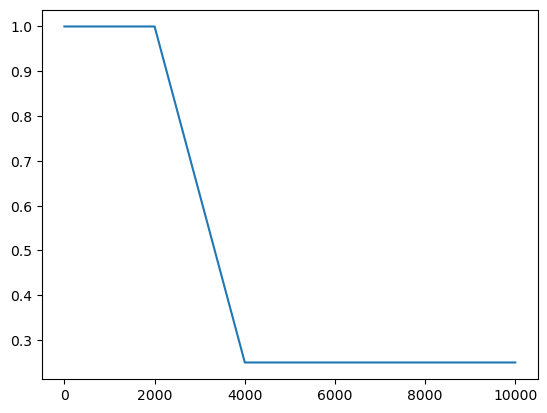

In [25]:
# This is the scheduled values of lambda - first we linearly decay from lambda=1.0 (only entropy) until a minimum value of lambda. Then we stay at that value of lambda for more iterations.
schedule_org = torch.cat(
    [
        torch.ones(cfg.source.pretraining_steps),
        torch.linspace(
            1.0,
            cfg.source.fin_lambda,
            cfg.source.linear_decay_steps,
        ),
        cfg.source.fin_lambda * torch.ones(cfg.source.lambda_steps),
    ]
)

print(schedule_org.shape)
plt.plot(schedule_org)

first_iteration_schedule = schedule_org.clone().detach()
next_iters_schedule = cfg.source.fin_lambda * torch.ones(cfg.source.pretraining_steps + cfg.source.linear_decay_steps + cfg.source.lambda_steps)

BUDGET_SCHEDULER = np.ones(cfg.sequential.number_of_iterations) / cfg.sequential.number_of_iterations
BUDGET_PER_ITERATION = (BUDGET_SCHEDULER * cfg.sequential.total_simulation_budget).astype(int) # divide budget uniformly

if cfg.sequential.frontloading:
    if cfg.sequential.front_frac > (1 / cfg.sequential.number_of_iterations):
        BUDGET_PER_ITERATION[0] = cfg.sequential.total_simulation_budget * cfg.sequential.front_frac # "frontload"
        remaining = cfg.sequential.total_simulation_budget * (1-cfg.sequential.front_frac)
        BUDGET_PER_ITERATION[1:] = remaining // (cfg.sequential.number_of_iterations-1) # divide remaining budget uniformly
    
print(BUDGET_PER_ITERATION)

## sequential approach begins

In [26]:
PRIOR_MAX, PRIOR_MIN

(tensor([  15, 1000,   70,  250,  100,   30,    3,  250,    3,  -50, 4000,  -35,
            3]),
 tensor([ 1.0000e-01,  2.0000e+01,  1.0000e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3000e+02,
          5.0000e+01, -9.0000e+01,  1.0000e-01]))

In [27]:
params_gpu = params.to(device)

In [28]:
## this is the initial distribution to sample unnormalized theta (!!!) from to train the surrogate
box_domain = VariableTemperedUniform(lower_bound=PRIOR_MIN, upper_bound=PRIOR_MAX)
# surro_theta = box_domain.sample(10_000).detach()
# surro_theta_norm = scale_tensor(surro_theta, PRIOR_MIN, PRIOR_MAX, -torch.ones(source_dim), torch.ones(source_dim))

In [29]:
def generate_data_from_box_prior(number, xs_all, device):

    source_dim=13
    from sourcerer.hh_utils import PRIOR_MAX, PRIOR_MIN
    from sourcerer.utils import scale_tensor
    from sourcerer.real_nvp import VariableTemperedUniform

    box_domain = VariableTemperedUniform(lower_bound=PRIOR_MIN, upper_bound=PRIOR_MAX)
    surro_theta = box_domain.sample(number).detach()
    surro_theta_norm = scale_tensor(surro_theta, PRIOR_MIN, PRIOR_MAX, -torch.ones(source_dim), torch.ones(source_dim))

    # nearest neighbours search
    # params_gpu = params_all.to(device)
    surro_theta_norm_gpu = surro_theta_norm.to(device)

    nns_idx = torch.zeros(surro_theta_norm.shape[0])
    for i, test_theta in enumerate(surro_theta_norm_gpu):
        test = test_theta.unsqueeze(0)
        #print(test.shape)
        dist = torch.norm(params_gpu - test, dim=1, p=2)
        #print(dist.shape)
        nns_idx[i] = dist.argmin().item()
        # print(i)
    # print(nns_idx)

    surro_push_forward_norm = xs_all[nns_idx.long()]
    return surro_theta_norm_gpu, surro_push_forward_norm.to(device)


def generate_data_from_source(domain_distribution, number, xs_all, device):

    surro_theta_norm = domain_distribution.sample(number).detach()
    # nearest neighbours search
    # params_gpu = params_all.to(device)
    surro_theta_norm_gpu = surro_theta_norm.to(device)

    nns_idx = torch.zeros(surro_theta_norm.shape[0])
    for i, test_theta in enumerate(surro_theta_norm_gpu):
        test = test_theta.unsqueeze(0)
        #print(test.shape)
        dist = torch.norm(params_gpu - test, dim=1, p=2)
        #print(dist.shape)
        nns_idx[i] = dist.argmin().item()
        # print(i)
    # print(nns_idx)

    surro_push_forward_norm = xs_all[nns_idx.long()]
    return surro_theta_norm_gpu, surro_push_forward_norm.to(device)

In [30]:
# th, xs = generate_data_from_source(source, 100, xs, device)

In [31]:
th

NameError: name 'th' is not defined

In [32]:
# xs

## prepare data for source

In [33]:
# # Load data and standardize to same scale as for training.
cfg.source.xo_path = './full_batch.npz'
npz = np.load(cfg.source.xo_path)
print(npz['theta'].shape); print(npz['stats'].shape)
# data = read_pickle(cfg.source.xo_path)
# print(data["X_o"].head())

full_xo_stats_np = npz["stats"]
num_xo = full_xo_stats_np.shape[0]
print(num_xo)

xo_stats_np = full_xo_stats_np[:, DEF_RESTRICTED]
xo_stats_np = xo_stats_np[np.where(~np.isnan(xo_stats_np).any(axis=1))[0]] #remove nan

xo_stats = torch.from_numpy(np.float32(xo_stats_np)) # unnormalized
print(f"after nan removal: {xo_stats.shape}")

supervised_mean = torch.tensor(
    [  # correct restricted 1 mil
        2.3512,
        -93.2657,
        -52.7358,
        278.4319,
        0.4392,
    ],
)

supervised_std = torch.tensor(
    [  # correct restricted 1 mil
        1.1922,
        20.0920,
        19.6483,
        300.1352,
        4.4579,
    ],
)
xo_stats_norm = (xo_stats - supervised_mean) / supervised_std
# xo_stats_norm = xo_stats_norm.to(device)


# take 1M samples to fit source
print(f'will train source on # {number_of_sims_source} observations')
xo_stats_norm = xo_stats_norm[:number_of_sims_source, :].to(device) # xo_stats_norm lives on GPU!!
print(xo_stats_norm.shape[0])

(15000000, 13)
(15000000, 23)
15000000
after nan removal: torch.Size([11303553, 5])
will train source on # 500000 observations
500000


In [34]:
train_losses = []
val_losses = []
train_source_losses = []

# surrogate quality metrics list (one value per iteration)
surro_c2sts = np.zeros(cfg.sequential.number_of_iterations)
surro_swds = np.zeros(cfg.sequential.number_of_iterations)

# source quality metrics list (one value per iteration)
source_simu_pf_swds = np.zeros(cfg.sequential.number_of_iterations)
source_simu_pf_c2sts = np.zeros(cfg.sequential.number_of_iterations)
source_surro_pf_c2sts = np.zeros(cfg.sequential.number_of_iterations) # these 2 are pfs
source_c2sts = np.zeros(cfg.sequential.number_of_iterations) # how well the source dists match? not necessary
source_entropies = np.zeros(cfg.sequential.number_of_iterations)

surro_train_domain_distribution = box_domain  # initialization

In [45]:
params_gpu.shape

torch.Size([14999995, 13])

In [46]:
print(f"naive sequential method on hodgkin-huxley with {cfg.sequential.number_of_iterations} iters and total budget: {cfg.sequential.total_simulation_budget}")
print(f"aggregating data? {cfg.sequential.collate_last_iter_data}, varying lambda over iters? {not cfg.sequential.lambda_stays_same}")
for iteration in range(cfg.sequential.number_of_iterations):
    print(f"ITER: {iteration+1}/{cfg.sequential.number_of_iterations} fitting surrogate with {BUDGET_PER_ITERATION[iteration]} samples")

    if iteration == 0:
        # here generate data from box domain
        surro_domain, surro_push_forward = generate_data_from_box_prior(number=BUDGET_PER_ITERATION[iteration], xs_all=xs, device=device)
        (surro_train_push_forward, surro_train_domain), (surro_val_push_forward, surro_val_domain) = train_val_split(
            surro_push_forward, surro_domain
        )
        print(f"first iter tr. data θ: {surro_train_domain.shape}, x: {surro_train_push_forward.shape}")
        print(f"first iter val data θ: {surro_val_domain.shape}, x: {surro_val_push_forward.shape}")
    
    else:
        # use the current source to generate data
        surro_domain, surro_push_forward = generate_data_from_source(domain_distribution=source,
                                                                     number=BUDGET_PER_ITERATION[iteration], xs_all=xs, device=device)
        
        # for subsequent iterations either collate or not
        if cfg.sequential.collate_last_iter_data:
            # concat data to (surro_train_push_forward, surro_train_domain), (surro_val_push_forward, surro_val_domain)
            (surro_train_push_forward_new, surro_train_domain_new), (surro_val_push_forward_new, surro_val_domain_new) = train_val_split(
                surro_push_forward, surro_domain
            )
            surro_train_domain = torch.cat((surro_train_domain, surro_train_domain_new), 0)
            surro_train_push_forward = torch.cat((surro_train_push_forward, surro_train_push_forward_new), 0)

            surro_val_domain = torch.cat((surro_val_domain, surro_val_domain_new), 0)
            surro_val_push_forward = torch.cat((surro_val_push_forward, surro_val_push_forward_new), 0)
            print(f"iter:{iteration+1} tr. data θ: {surro_train_domain.shape}, x: {surro_train_push_forward.shape}")
            print(f"iter:{iteration+1} val data θ: {surro_val_domain.shape}, x: {surro_val_push_forward.shape}")
        
        else:
            (surro_train_push_forward, surro_train_domain), (surro_val_push_forward, surro_val_domain) = train_val_split(
                surro_push_forward, surro_domain
            )
            # print(f"iter:{iteration+1} tr. data θ: {surro_train_domain.shape}, x: {surro_train_push_forward.shape}")
            # print(f"iter:{iteration+1} val data θ: {surro_val_domain.shape}, x: {surro_val_push_forward.shape}")

    train_dataset = create_dataloader(surro_train_push_forward, surro_train_domain)
    val_dataset = create_dataloader(surro_val_push_forward, surro_val_domain)

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=250, #//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs? no we need surrogate to converge
        early_stopping_patience=10_000,
        print_every=50, # don't print often
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k normalized thetas
        gt_surrogate = surrogate.sample(context=gt_source.to(device))  # forward pass produces standardized x-s
        gt_surrogate_two = surrogate.sample(context=gt_source_two.to(device))

    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu())) # both are standardized
    current_swd = sliced_wasserstein_distance(gt_simulator.to(device), gt_surrogate,
                                          num_projections=4096, device=device).item()

    surro_c2sts[iteration] = current_c2st
    surro_swds[iteration] = current_swd
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration+1}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration+1}: {current_swd}")

    torch.cuda.empty_cache() # needed!!
    """
        source fitting
    """
    
    schedule = schedule_org
    if cfg.sequential.lambda_stays_same:
        schedule = first_iteration_schedule if iteration==0 else next_iters_schedule

    train_source_loss = train_source(
        data=xo_stats_norm,  # note that we are passing standardized x-s to fit the source
        source_model=source,
        simulator=surrogate, ##### ALWAYS PASSING SURROGATE HERE FOR NAIVE SEQUENTIAL METHOD!!!
        optimizer=optimizer,
        entro_dist=None,
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,
        wasser_np=cfg.source.wasserstein_slices,
        use_log_sw=cfg.source.use_log_sw,
        num_chunks=cfg.source.num_chunks,
        epochs=cfg.source.pretraining_steps
        + cfg.source.linear_decay_steps
        + cfg.source.lambda_steps,
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience,
        device=device,
        print_every=1000,
    )
    train_source_losses.extend(train_source_loss)

    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        estimated_source = source.sample(10_000) # so we are assumung the source generates thetas in [-1, 1], because it is trained on standardized x-s
        moved_estimated_source = scale_tensor(   # then move it to the actual range if we wish to pass it through the simulator
            estimated_source.cpu(),
            -torch.ones(source_dim),
            torch.ones(source_dim),
            PRIOR_MIN,
            PRIOR_MAX,
        )
        surro_estimated_pf = surrogate.sample(10_000, estimated_source) # surrogate expects normalized source, standardized x-s
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu())) # both standardized
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    nns_idx = torch.zeros(estimated_source.shape[0])
    for i, test_theta in enumerate(estimated_source):
        test = test_theta.unsqueeze(0)
        #print(test.shape)
        dist = torch.norm(params_gpu - test, dim=1, p=2)
        #print(dist.shape)
        nns_idx[i] = dist.argmin().item()
        # print(i)

    nns_estimated_pf = xs[nns_idx.long()]
    nns_c2st = np.mean(c2st_scores(nns_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC (NNS estimate): {nns_c2st}")

    source_simu_pf_c2sts[iteration] = nns_c2st
    source_surro_pf_c2sts[iteration] = surro_c2st

    # plot true and learned sources
    fig_source = corner(
        gt_source_two.cpu().numpy(), # old θ-s from the actual prior theta
        color="black",
        bins=20,
        hist_kwargs={"density": True},
        plot_contours=False,
        plot_density=False,
        labels=theta_labels,
        # plot_datapoints=False,
    )
    corner(
        estimated_source.cpu().numpy(),
        fig=fig_source,
        color="red",
        bins=20,
        hist_kwargs={"density": True},
        plot_contours=False,
        plot_density=False,
        labels=theta_labels,
        # plot_datapoints=False,
    )
    fig_source.suptitle(f'source after iter: {iteration+1}/{cfg.sequential.number_of_iterations}')
    
    save_fig(
        fig_source,
        file_name=f"{cfg.base.tag}_source_fig_iter_{iteration+1}.pdf",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    plt.close(fig_source)
    

    

    estimated_source_kole = kozachenko_leonenko_estimator(estimated_source, on_torus=False).item()
    print(f"Estimated source entropy estimate: {estimated_source_kole}")

    ## update the source for next iteration of updating the surrogate
    surro_train_domain_distribution = source
    print("--__--"*10)


    torch.cuda.empty_cache()

naive sequential method on hodgkin-huxley with 3 iters and total budget: 1000000
aggregating data? True, varying lambda over iters? False
ITER: 1/3 fitting surrogate with 333333 samples
first iter tr. data θ: torch.Size([266666, 13]), x: torch.Size([266666, 5])
first iter val data θ: torch.Size([66667, 13]), x: torch.Size([66667, 5])
Epoch: 0, Train Loss: 0.35967362028566296, Val Loss: 0.32703537753715367
Epoch: 50, Train Loss: 0.26886936287161484, Val Loss: 0.339051684771461
Epoch: 100, Train Loss: 0.2194299970158231, Val Loss: 0.36722147053685683
Epoch: 150, Train Loss: 0.19624945156690943, Val Loss: 0.38581655502776074
Epoch: 200, Train Loss: 0.1846408459738669, Val Loss: 0.3867633323331446
Surrogate vs Simulator y-space C2ST AUC after iteration 1: 0.8481500000000001
Surrogate vs Simulator y-space SWD AUC after iteration 1: 0.1650976538658142
Epoch x Chunk: 0, Weighted Loss: 16.429050065637313, Entropy loss: 16.429050065637313, Wasser loss: -0.22685903310775757
Epoch x Chunk: 1000, 

In [50]:
cfg.sequential

{'self': 'naive', 'total_simulation_budget': 1000000, 'number_of_iterations': 3, 'subsampling': False, 'collate_last_iter_data': True, 'lambda_stays_same': True, 'frontloading': False, 'front_frac': 0.3, 'number_of_sims_source': 500000}

In [47]:
# theta_labels

In [48]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Jan 13 21:04:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:81:00.0 Off |                    0 |
| N/A   35C    P0              45W / 250W |   1693MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [29]:
params.shape

torch.Size([14999995, 13])

In [30]:
# surro_theta = box_domain.sample(10_000).detach()
# # this step is not necessary if source model is used to sample the surro_theta
# surro_theta_norm = scale_tensor(surro_theta, PRIOR_MIN, PRIOR_MAX, -torch.ones(source_dim), torch.ones(source_dim)) # push in [-1, 1]
# surro_theta_norm

In [31]:
# params_gpu = params.to(device)
# surro_theta_norm_gpu = surro_theta_norm.to(device)

In [32]:
# nns_idx = torch.zeros(surro_theta_norm.shape[0])
# for i, test_theta in enumerate(surro_theta_norm_gpu):
#     test = test_theta.unsqueeze(0)
#     #print(test.shape)
#     dist = torch.norm(params_gpu - test, dim=1, p=2)
#     #print(dist.shape)
#     nns_idx[i] = dist.argmin().item()
#     # print(i)

In [33]:
# params[nns_idx.long()]

In [34]:
# xs[nns_idx.long()]

In [35]:
# surro_push_forward = run_hh_simulator(surro_theta, M1_model)
# # correct their means
# surro_push_forward_norm = (surro_push_forward - supervised_mean) / supervised_std

In [36]:
# def generate_data_for_surrogate(simulator, domain_distribution, number, supervised_mean, supervised_std):
#     """
#         uses the actual simulator, takes too much time!
#     """
    
#     source_dim=13
#     surro_theta = domain_distribution.sample(number).detach() # this is the source
#     surro_theta_norm = scale_tensor(surro_theta, PRIOR_MIN, PRIOR_MAX, -torch.ones(source_dim), torch.ones(source_dim)) # push in [-1, 1]
    
#     surro_push_forward = run_hh_simulator(surro_theta, simulator)
#     surro_push_forward_norm = (surro_push_forward - supervised_mean) / supervised_std
#     # surro_push_forward = simulator.sample(surro_theta)
#     return surro_theta_norm, surro_push_forward # freshly sampled (theta, y) pairs to train surrogate

In [77]:
surro_domain, surro_push_forward = generate_data_from_source(domain_distribution=source, number=10_000, params_all=params, xs_all=xs, device=device)

In [78]:
surro_domain

tensor([[ 0.7801,  0.3755,  0.6756,  ...,  0.8267, -0.6277, -0.4014],
        [-0.1290,  0.7820, -0.9986,  ...,  0.6813, -0.0644,  0.9136],
        [ 0.5879,  0.4169, -0.5311,  ...,  0.6783,  0.2718, -0.9381],
        ...,
        [ 0.6083,  0.6532, -0.0214,  ...,  0.0519,  0.6057, -0.9317],
        [-0.8750,  0.3452,  0.2036,  ..., -0.3107, -0.0064,  0.2117],
        [ 0.6325,  0.8681,  0.2743,  ...,  0.2527,  0.1495, -0.5308]],
       device='cuda:0')

In [79]:
surro_push_forward

tensor([[ 1.0563, -0.5432, -0.6271,  1.2252,  0.4456],
        [-0.1294,  0.9071,  2.1683, -0.9149,  2.8510],
        [ 1.5911, -1.2001,  0.1589,  0.4125,  0.2673],
        ...,
        [ 1.3734, -1.4834, -0.3105,  0.7081,  0.2996],
        [-0.8096, -1.0385, -0.6185, -0.7741,  0.6036],
        [-0.8096,  1.1355,  1.7424, -0.8559, -1.0691]])

In [80]:
surro_push_forward_hh = run_hh_simulator(scale_tensor(surro_domain.cpu(), -torch.ones(source_dim), torch.ones(source_dim), PRIOR_MIN, PRIOR_MAX),
                                         M1_model
                                        )
# correct their means
surro_push_forward_norm_hh = (surro_push_forward_hh - supervised_mean) / supervised_std
surro_push_forward_norm_hh

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:552: RuntimeWarning: invalid value encountered in log
  np.log(AP_amp_adapt),
 [py.warnings]
  np.log(AP_amp_adapt),

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:39: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-steepness * (x - offset)))
 [py.warnings]
  return 1 / (1 + np.exp(-steepness * (x - offset)))



tensor([[ 1.1630, -0.6042, -0.7078,  1.5755,  0.4542],
        [ 4.0185,  0.9735,  3.2307, -0.8907,  2.9382],
        [ 1.6929, -1.4046,  0.2235,  0.3808,  0.2642],
        ...,
        [ 1.3421, -1.7038, -0.0918,  0.4175,  0.2623],
        [-0.8093, -0.5511, -0.6065, -0.8057,  0.8125],
        [-0.8093,  0.9250,  1.6092, -0.8497, -0.9333]])

In [81]:
surro_push_forward

tensor([[ 1.0563, -0.5432, -0.6271,  1.2252,  0.4456],
        [-0.1294,  0.9071,  2.1683, -0.9149,  2.8510],
        [ 1.5911, -1.2001,  0.1589,  0.4125,  0.2673],
        ...,
        [ 1.3734, -1.4834, -0.3105,  0.7081,  0.2996],
        [-0.8096, -1.0385, -0.6185, -0.7741,  0.6036],
        [-0.8096,  1.1355,  1.7424, -0.8559, -1.0691]])

In [90]:
idx = np.random.randint(5000)
print(idx)
surro_push_forward_norm_hh[idx], surro_push_forward[idx]

475


(tensor([ 1.1008,  0.6347, -0.1694,  0.7274,  0.5468]),
 tensor([ 1.2205,  0.2665, -0.1021,  1.0543,  0.4997]))

In [100]:
surro_domain, surro_push_forward = generate_data_from_box_prior(number=10_000, params_all=params, xs_all=xs, device=device)

In [101]:
surro_domain

tensor([[ 0.9652, -0.8092, -0.1223,  ...,  0.0948,  0.7583, -0.9831],
        [-0.3677,  0.4256,  0.7577,  ...,  0.3869,  0.9135,  0.4765],
        [-0.2306,  0.1083, -0.4683,  ...,  0.9463, -0.2691, -0.3941],
        ...,
        [-0.1515, -0.7905, -0.2715,  ..., -0.1966, -0.8074,  0.7163],
        [ 0.2920, -0.4501,  0.5503,  ...,  0.7602,  0.3877, -0.3055],
        [ 0.8764, -0.0419, -0.6472,  ...,  0.8650,  0.2729, -0.4607]])

In [96]:
# gt_source_moved = scale_tensor(surro_domain, -torch.ones(source_dim), torch.ones(source_dim), PRIOR_MIN, PRIOR_MAX)

In [102]:
surro_push_forward_hh = run_hh_simulator(scale_tensor(surro_domain, -torch.ones(source_dim), torch.ones(source_dim), PRIOR_MIN, PRIOR_MAX),
                                         M1_model
                                        )
# correct their means
surro_push_forward_norm_hh = (surro_push_forward_hh - supervised_mean) / supervised_std

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:39: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-steepness * (x - offset)))
 [py.warnings]
  return 1 / (1 + np.exp(-steepness * (x - offset)))

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:39: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-steepness * (x - offset)))
 [py.warnings]
  return 1 / (1 + np.exp(-steepness * (x - offset)))



In [103]:
surro_push_forward_norm_hh

tensor([[-1.0507e+00, -1.5777e-01, -7.4892e-01, -8.6732e-01, -1.0646e+00],
        [ 1.1220e+00,  8.4085e-01,  7.2151e-02,  7.1320e-01,  2.4810e-01],
        [ 1.4621e+00, -9.1487e-01,  2.7908e-01,  3.4146e+00,  3.0481e-01],
        ...,
        [ 2.9932e-01,  6.6234e-01, -9.6302e-01,  2.0004e+00,  6.1676e-01],
        [-1.0507e+00, -1.5419e-01,  1.4583e-03, -8.0749e-01, -1.2023e+00],
        [-8.0935e-01, -1.3584e+00,  7.2164e-01, -4.7358e-02,  2.9540e-02]])

In [104]:
surro_push_forward

tensor([[-1.0509, -0.1467, -1.0730, -0.8796, -0.9146],
        [ 1.1824,  1.2569,  0.1107,  1.2109,  0.2668],
        [ 0.9854, -1.4768, -0.3591,  2.0739,  0.5157],
        ...,
        [ 0.5403,  0.1707, -0.9889,  1.4332,  0.5591],
        [-1.0509,  0.2658, -0.2452, -0.8535, -1.0460],
        [ 1.0334, -1.3803,  0.1499,  0.1655,  0.1460]])

In [44]:
print(f"naive sequential method on hodgkin-huxley with {cfg.sequential.number_of_iterations} iters and total budget: {cfg.sequential.total_simulation_budget}")
print(f"aggregating data? {cfg.sequential.collate_last_iter_data}, varying lambda over iters? {not cfg.sequential.lambda_stays_same}")
for iteration in range(cfg.sequential.number_of_iterations):
    print(f"ITER: {iteration+1}/{cfg.sequential.number_of_iterations} fitting surrogate with {BUDGET_PER_ITERATION[iteration]} samples")

    surro_domain, surro_push_forward = generate_data_for_surrogate(simulator,
                                                                   surro_train_domain_distribution,
                                                                   number=BUDGET_PER_ITERATION[iteration]
                                                                  )
    if iteration == 0:
        # here generate data from box domain
        (surro_train_push_forward, surro_train_domain), (surro_val_push_forward, surro_val_domain) = train_val_split(
            surro_push_forward, surro_domain
        )
        # print(f"first iter tr. data θ: {surro_train_domain.shape}, x: {surro_train_push_forward.shape}")
        # print(f"first iter val data θ: {surro_val_domain.shape}, x: {surro_val_push_forward.shape}")
    
    else:
        # for subsequent iterations either collate or not
        if cfg.sequential.collate_last_iter_data:
            # concat data to (surro_train_push_forward, surro_train_domain), (surro_val_push_forward, surro_val_domain)
            (surro_train_push_forward_new, surro_train_domain_new), (surro_val_push_forward_new, surro_val_domain_new) = train_val_split(
                surro_push_forward, surro_domain
            )
            surro_train_domain = torch.cat((surro_train_domain, surro_train_domain_new), 0)
            surro_train_push_forward = torch.cat((surro_train_push_forward, surro_train_push_forward_new), 0)

            surro_val_domain = torch.cat((surro_val_domain, surro_val_domain_new), 0)
            surro_val_push_forward = torch.cat((surro_val_push_forward, surro_val_push_forward_new), 0)
            print(f"iter:{iteration+1} tr. data θ: {surro_train_domain.shape}, x: {surro_train_push_forward.shape}")
            print(f"iter:{iteration+1} val data θ: {surro_val_domain.shape}, x: {surro_val_push_forward.shape}")
        
        else:
            (surro_train_push_forward, surro_train_domain), (surro_val_push_forward, surro_val_domain) = train_val_split(
                surro_push_forward, surro_domain
            )
            # print(f"iter:{iteration+1} tr. data θ: {surro_train_domain.shape}, x: {surro_train_push_forward.shape}")
            # print(f"iter:{iteration+1} val data θ: {surro_val_domain.shape}, x: {surro_val_push_forward.shape}")

    train_dataset = create_dataloader(surro_train_push_forward, surro_train_domain)
    val_dataset = create_dataloader(surro_val_push_forward, surro_val_domain)

    

    






    

naive sequential method on hodgkin-huxley with 2 iters and total budget: 500000
aggregating data? True, varying lambda over iters? False
ITER: 1/2 fitting surrogate with 250000 samples
ITER: 2/2 fitting surrogate with 250000 samples


In [41]:
# def simulate_from_prior(hh_simulator, prior, num_obs):
    
#     prior_samples = prior.sample(num_obs)
#     simu_box_pf = hh_simulator.simulation_wrapper(prior_samples)

#     simu_box_pf_np = simu_box_pf.numpy()
#     # same procedure as above (this is a bit messy)
#     simu_box_pf_np = simu_box_pf.numpy()
    
#     strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
#     print(np.sum(strict_keeping_box))
    
#     def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]
    
#     def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
#     print(np.sum(def_keeping_box))
#     def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
#     def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
#     print(np.sum(def_keeping_box))

In [43]:
# # Plot some traces from simulated pushforward of reference box prior
# num_xo = 10_000
# prior = VariableTemperedUniform(lower_bound=PRIOR_MIN, upper_bound=PRIOR_MAX)
# prior_samples = prior.sample(num_xo)

# simu_box_pf = M1_model.simulation_wrapper(prior_samples)

# # same procedure as above (this is a bit messy)
# simu_box_pf_np = simu_box_pf.numpy()

# strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
# print(np.sum(strict_keeping_box))

# def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]

# def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
# print(np.sum(def_keeping_box))
# def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
# def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
# print(np.sum(def_keeping_box))

## initialize surrogate

In [44]:
# cfg.surrogate.ydim = 5
cfg.surrogate

{'self': 'hh_train_surrogate', 'num_training_samples': 500000, 'xdim': 13, 'ydim': 5, 'num_hidden_layers': 4, 'hidden_layer_dim': 256, 'nb_epochs': 250, 'surrogate_lr': 0.0005, 'surrogate_weight_decay': 1e-05, 'early_stopping_patience': 50}

In [45]:
# Define surrogate model
# surrogate = HHSurro(hidden_layer_dim=256, xdim=13, ydim=5).to(device) # hardcoded
# optimizer = optim.Adam(surrogate.parameters(), lr=5e-4, weight_decay=1e-5)
surrogate = HHSurro(hidden_layer_dim=cfg.surrogate.hidden_layer_dim,
                    xdim=cfg.surrogate.xdim,
                    ydim=cfg.surrogate.ydim
                   ).to(device)

optimizer = optim.Adam(surrogate.parameters(),
                       lr=cfg.surrogate.surrogate_lr, # 5e-4
                       weight_decay=cfg.surrogate.surrogate_weight_decay # 1e-5
                      )

assert cfg.surrogate.self == 'hh_train_surrogate'

# this will be moved to inside the loop later
training_dataset, validation_dataset = create_train_val_dataloaders(
    y=stats_torch.to(device),
    x=source.to(device),
    batch_size=4096,
    validation_size=0.2,
    random_state=0,
)

In [46]:
number_of_sims_surrogate

500000

In [47]:
# Train surrogate model with `number_of_sims_surrogate` training samples
training_loss, validation_loss = fit_conditional_normalizing_flow(
    network=surrogate,
    optimizer=optimizer,
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    nb_epochs=200, # can afford high nb_epochs if <100k samples are used
    # early_stopping_patience=20,
    early_stopping_patience=10000,
    print_every=50,
)

Epoch: 0, Train Loss: 0.29586153218940814, Val Loss: 0.19775343775749207
Epoch: 50, Train Loss: 0.04026485561412208, Val Loss: 0.05763900905847549
Epoch: 100, Train Loss: 0.03148659176136158, Val Loss: 0.05874915465712547
Epoch: 150, Train Loss: 0.02495483358447649, Val Loss: 0.05699021384119987


In [48]:
# # Train surrogate model with `number_of_sims_surrogate` training samples
# training_loss, validation_loss = fit_conditional_normalizing_flow(
#     network=surrogate,
#     optimizer=optimizer,
#     training_dataset=training_dataset,
#     validation_dataset=validation_dataset,
#     nb_epochs=500, # can afford high nb_epochs if <100k samples are used
#     # early_stopping_patience=20,
#     early_stopping_patience=10000,
#     print_every=50,
# )

## save surrogate

In [49]:
torch.save(
    surrogate.state_dict(),
    f"hh_surrogate_epochs_{250}_sims_{number_of_sims_surrogate}.pt",
)

## load surrogate if don't want to train

In [50]:
# # Load surrogate model
# ydim = 5
# surrogate = HHSurro(hidden_layer_dim=256, xdim=13, ydim=ydim).to(device)

# state_dict = torch.load('./hh_surrogate_epochs_250_sims_500000.pt')
# surrogate.load_state_dict(state_dict)
# surrogate = surrogate.to(device)

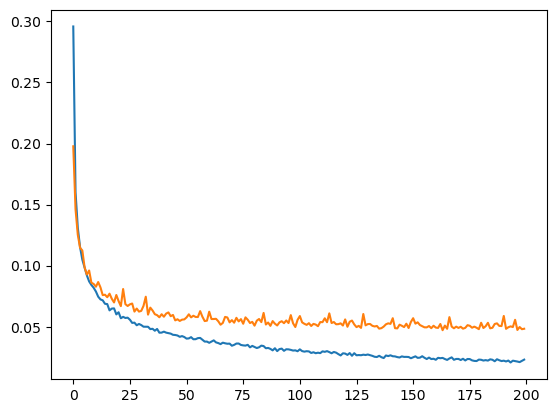

In [51]:
# %%
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()
# %%

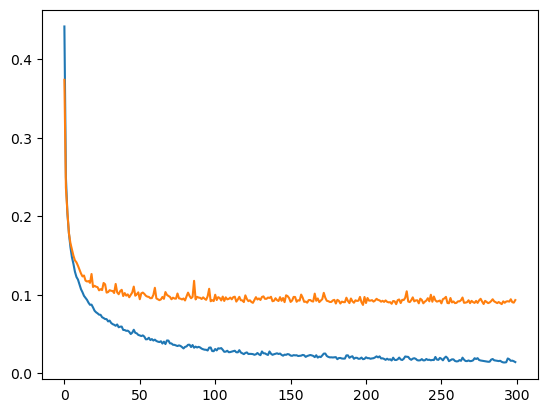

In [18]:
# %%
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()
# %%

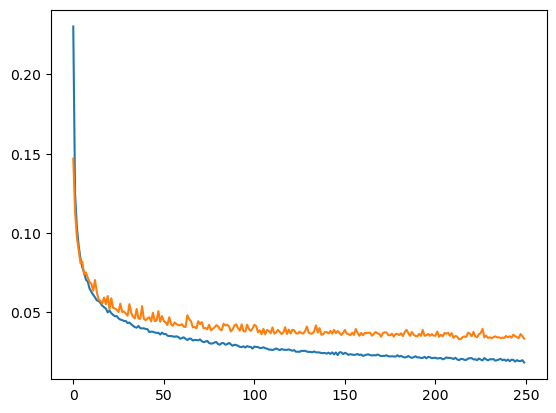

In [79]:
# %%
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()
# %%

In [52]:
surrogate.eval()
with torch.no_grad():
    val_loss = 0.0
    for batch_Y, batch_X in validation_dataset:
        output = surrogate.sample(context=batch_X.to(device))  # forward pass
        loss = surrogate.forward_kld(batch_Y.to(device), batch_X.to(device))
        val_loss += loss.item()

print(val_loss / len(validation_dataset))
print(len(validation_dataset))

0.04833336159586907
25


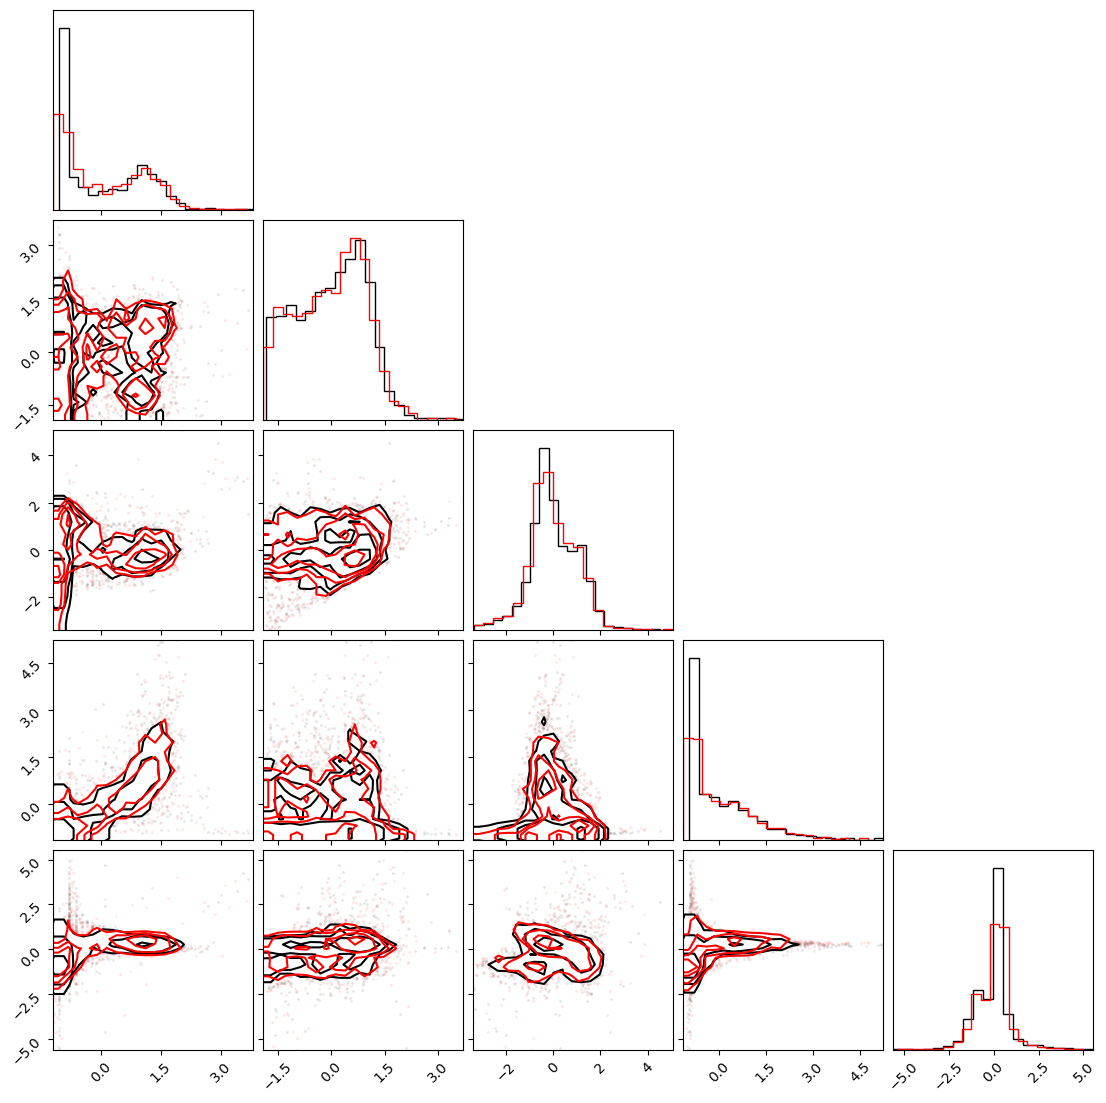

In [54]:
# %%
# Plot surrogate outputs vs. real data.
fig1 = corner(
    batch_Y.cpu().numpy(),
    hist_kwargs={"density": True},
    plot_density=False,
    # plot_contours=False,
)
corner(
    output.cpu().numpy(),
    hist_kwargs={"density": True},
    fig=fig1,
    color="red",
    plot_density=False,
    # plot_contours=False,
)

pass

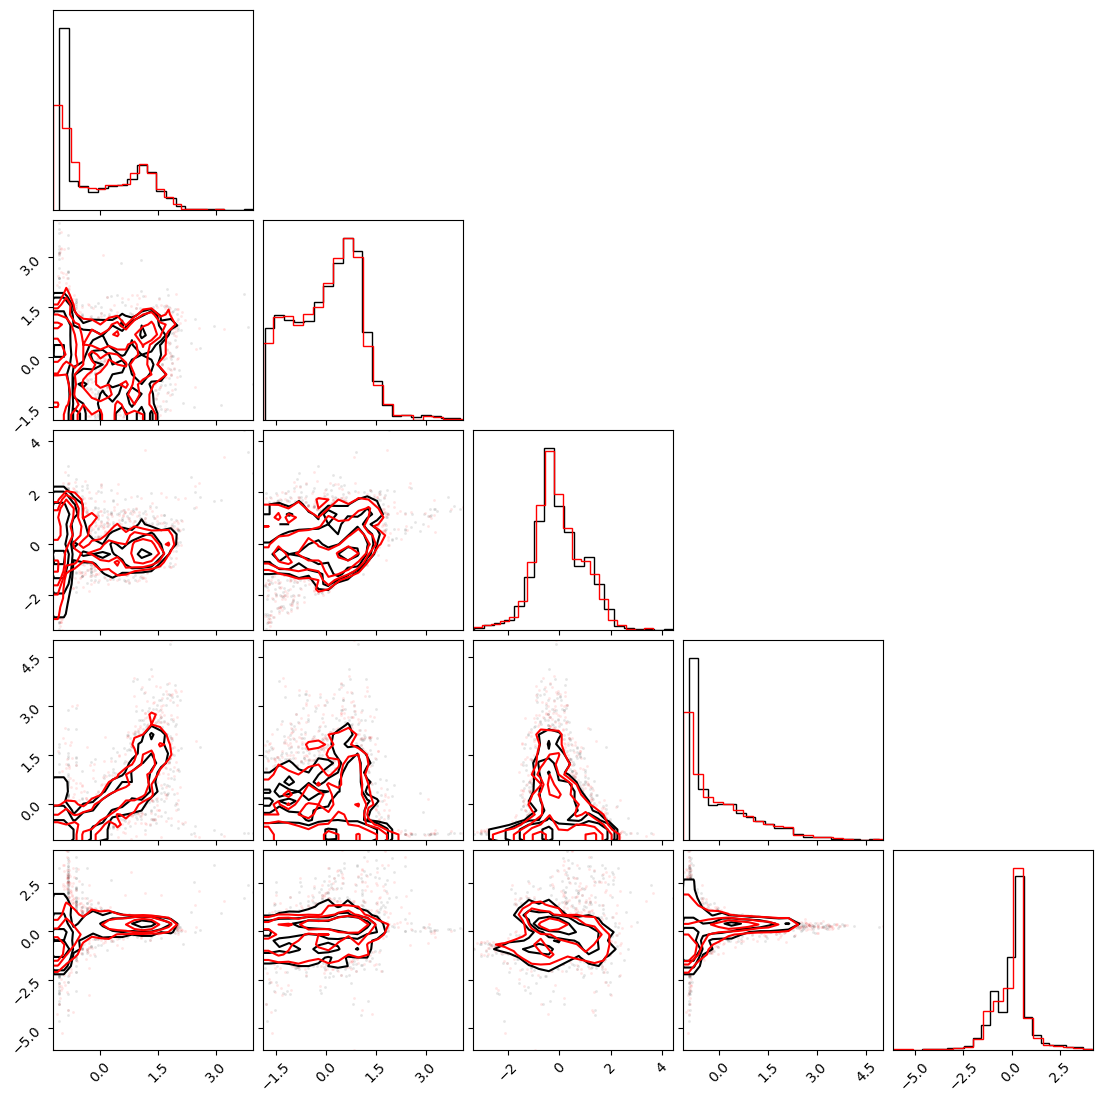

In [19]:
# %%
# Plot surrogate outputs vs. real data.
fig1 = corner(
    batch_Y.cpu().numpy(),
    hist_kwargs={"density": True},
    plot_density=False,
    # plot_contours=False,
)
corner(
    output.cpu().numpy(),
    hist_kwargs={"density": True},
    fig=fig1,
    color="red",
    plot_density=False,
    # plot_contours=False,
)

pass

## surrogate quality metrics like c2st

In [55]:
source.shape, stats_torch.shape

(torch.Size([500000, 13]), torch.Size([500000, 5]))

In [56]:
params.shape, xs.shape

(torch.Size([14999995, 13]), torch.Size([14999995, 5]))

In [57]:
# # number_of_sims = 0
# gt_source = params[number_of_sims_surrogate:number_of_sims_surrogate+10_000, :] # 10k thetas from true source distribution
# gt_source_two = params[number_of_sims_surrogate+10_000:number_of_sims_surrogate+20_000, :] # 10k thetas from true source distribution

# gt_simulator = xs[number_of_sims_surrogate:number_of_sims_surrogate+10_000, :]
# gt_simulator_two = xs[number_of_sims_surrogate+10_000:number_of_sims_surrogate+20_000, :]

# gt_source.shape, gt_simulator.shape

In [58]:
expected_distance = sliced_wasserstein_distance(
    gt_simulator.to(device),     # from theta1
    gt_simulator_two.to(device), # from theta2 (both ground truth)
    num_projections=4096,
    device=device,
).item()
print(f"Sliced wassertein distance on groundtruth y (expected/baseline swd): {expected_distance}, log: {np.log(expected_distance)}")

Sliced wassertein distance on groundtruth y (expected/baseline swd): 0.028164738789200783, log: -3.569684480983427


In [59]:
surrogate.eval()
with torch.no_grad():
    # surrogate generated observations from the above 2 sets of 10k normalized thetas
    gt_surrogate = surrogate.sample(context=gt_source.to(device))  # forward pass produces standardized x-s
    gt_surrogate_two = surrogate.sample(context=gt_source_two.to(device))

current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu())) # both are standardized
current_swd = sliced_wasserstein_distance(gt_simulator.to(device), gt_surrogate,
                                          num_projections=4096,
                                          device=device
                                         ).item()
print(f"Surrogate vs Simulator y-space C2ST AUC: {current_c2st}")
print(f"Surrogate vs Simulator y-space SWD AUC: {current_swd}")

Surrogate vs Simulator y-space C2ST AUC: 0.7544500000000001
Surrogate vs Simulator y-space SWD AUC: 0.032261744141578674


In [60]:
gt_simulator.mean(0), gt_surrogate.mean(0)

(tensor([ 0.0155, -0.0043, -0.0107,  0.0038,  0.0079]),
 tensor([ 0.0221, -0.0133, -0.0201,  0.0197,  0.0253], device='cuda:0'))

## c2st on more samples

In [61]:
# # this samples were part of training data
# gt_source_left = params[:10_000, :]
# gt_simulator_left = xs[:10_000, :]

# print(gt_source_left.shape, gt_simulator_left.shape)

# surrogate.eval()
# with torch.no_grad():
#     # surrogate generated observations
#     gt_surrogate_left = surrogate.sample(context=gt_source_left.to(device))  # forward pass

# current_c2st = np.mean(c2st_scores(gt_simulator_left.cpu(), gt_surrogate_left.cpu()))
# current_swd = sliced_wasserstein_distance(gt_simulator_left.to(device), gt_surrogate_left,
#                                           num_projections=4096,
#                                           device=device
#                                          ).item()
# print(f"Surrogate vs Simulator y-space C2ST AUC: {current_c2st}")
# print(f"Surrogate vs Simulator y-space SWD AUC: {current_swd}")

In [62]:
# gt_source_left = params[number_of_sims_surrogate+50_000:number_of_sims_surrogate+90_000, :]
# gt_simulator_left = xs[number_of_sims_surrogate+50_000:number_of_sims_surrogate+90_000, :]

# print(gt_source_left.shape, gt_simulator_left.shape)

# surrogate.eval()
# with torch.no_grad():
#     # surrogate generated observations
#     gt_surrogate_left = surrogate.sample(context=gt_source_left.to(device))  # forward pass

# current_c2st = np.mean(c2st_scores(gt_simulator_left.cpu(), gt_surrogate_left.cpu()))
# current_swd = sliced_wasserstein_distance(gt_simulator_left.to(device), gt_surrogate_left,
#                                           num_projections=4096,
#                                           device=device
#                                          ).item()
# print(f"Surrogate vs Simulator y-space C2ST AUC: {current_c2st}")
# print(f"Surrogate vs Simulator y-space SWD AUC: {current_swd}")

In [63]:
surrogate

HHSurro(
  (mse): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [64]:
# # %%
# rand_id = np.random.randint(0, batch_Y.shape[0])
# print(batch_Y[rand_id, :])
# print(output[rand_id, :])

# print("aggregate")
# print(torch.mean(torch.abs(batch_Y - output), dim=0))
# print(torch.mean(batch_Y - output, dim=0))
# print(torch.std(torch.abs(batch_Y - output), dim=0))



In [66]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Jan 12 13:43:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:E1:00.0 Off |                    0 |
| N/A   31C    P0              56W / 250W |    705MiB / 40960MiB |     19%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [67]:
# # Define config
# # NOTE: These overrides only take effect if this script is run interactively
# local_overrides = [
#     "base.tag=debug",
#     "base.folder=misc",
#     "source=wasserstein_hh",
#     "source.fin_lambda=0.25",
#     "surrogate=load_hh_surrogate",
#     "surrogate.ydim=5",
#     # "surrogate.surrogate_path=../results_sourcerer/surrogates/hh_surrogate.pt",
#     "surrogate.surrogate_path=./hh_surrogate_epochs_100.pt",
# ]

# cfg = script_or_command_line_cfg(
#     config_name="config",
#     config_path="../conf",
#     local_overrides=local_overrides,
#     name=__name__,
# )

# assert cfg.base.tag is not None
# assert cfg.base.folder is not None

# print(OC.to_yaml(cfg))

# save_cfg_as_yaml(
#     cfg,
#     f"{cfg.base.tag}_cfg.yaml",
#     folder=cfg.base.folder,
#     base_path=cfg.base.base_path,
# )


# if cfg.base.seed is None:
#     random_random_seed = np.random.randint(2**16)
#     set_seed(random_random_seed)
#     save_numpy_csv(
#         np.array([random_random_seed], dtype=int),
#         file_name=f"{cfg.base.tag}_seed.csv",
#         folder=cfg.base.folder,
#         base_path=cfg.base.base_path,
#     )
# else:
#     set_seed(cfg.base.seed)

In [68]:
print(f"theta/parameter dimension: {cfg.surrogate.xdim}")
print(f"x/observation dimension: {cfg.surrogate.ydim}")

theta/parameter dimension: 13
x/observation dimension: 5


In [69]:
cfg.source.xo_path = './full_batch.npz'
cfg.source

{'self': 'wasserstein_hh', 'xo_path': './full_batch.npz', 'wasserstein_slices': 500, 'wasserstein_order': 2, 'use_log_sw': True, 'num_chunks': 1, 'num_kole_samples': 512, 'pretraining_steps': 2000, 'linear_decay_steps': 2000, 'lambda_steps': 11000, 'fin_lambda': 0.25, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'early_stopping_patience': 1000000}

## load data file again but this time for source

In [70]:
# # Load data and standardize to same scale as for training.
# npz = np.load(cfg.source.xo_path)
# print(npz['theta'].shape); print(npz['stats'].shape)
# # data = read_pickle(cfg.source.xo_path)
# # print(data["X_o"].head())

In [71]:
number_of_sims_surrogate

500000

In [72]:
# def f():
#     full_xo_stats_np = npz["stats"]
#     num_xo = full_xo_stats_np.shape[0]
#     print(num_xo)
    
#     xo_stats_np = full_xo_stats_np[:, DEF_RESTRICTED]
#     print(np.where(np.isnan(xo_stats_np).any(axis=1))[0])
#     print(np.isnan(xo_stats_np).any(axis=1).sum())
# f()

In [74]:
# # Load data and standardize to same scale as for training.
npz = np.load(cfg.source.xo_path)
print(npz['theta'].shape); print(npz['stats'].shape)
# data = read_pickle(cfg.source.xo_path)
# print(data["X_o"].head())

full_xo_stats_np = npz["stats"]
num_xo = full_xo_stats_np.shape[0]
print(num_xo)

xo_stats_np = full_xo_stats_np[:, DEF_RESTRICTED]
xo_stats_np = xo_stats_np[np.where(~np.isnan(xo_stats_np).any(axis=1))[0]] #remove nan

xo_stats = torch.from_numpy(np.float32(xo_stats_np)) # unnormalized
print(f"after nan removal: {xo_stats.shape}")

supervised_mean = torch.tensor(
    [  # correct restricted 1 mil
        2.3512,
        -93.2657,
        -52.7358,
        278.4319,
        0.4392,
    ],
)

supervised_std = torch.tensor(
    [  # correct restricted 1 mil
        1.1922,
        20.0920,
        19.6483,
        300.1352,
        4.4579,
    ],
)
xo_stats_norm = (xo_stats - supervised_mean) / supervised_std
# xo_stats_norm = xo_stats_norm.to(device)


# take 1M samples to fit source
print(f'will train source on # {number_of_sims_source} observations')
xo_stats_norm = xo_stats_norm[:number_of_sims_source, :].to(device) # xo_stats_norm lives on GPU!!
print(xo_stats_norm.shape[0])

(15000000, 13)
(15000000, 23)
15000000
after nan removal: torch.Size([11303553, 5])
will train source on # 250000 observations
250000


In [75]:
xo_stats_np.shape

(11303553, 5)

In [76]:
number_of_sims_surrogate, number_of_sims_source

(500000, 250000)

In [77]:
xo_stats_norm.shape[0] / 1e6

0.25

In [78]:
# Define source flows
if cfg.source_model.self == "sampler":
    source = Sampler(
        xdim=cfg.surrogate.xdim,
        input_noise_dim=cfg.surrogate.xdim,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        num_hidden_layers=cfg.source_model.num_hidden_layers,
    )
elif cfg.source_model.self == "real_nvp":
    source = RealNVPs(
        data_dim=cfg.surrogate.xdim,
        context_dim=0,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        flow_length=cfg.source_model.flow_length,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
else:
    raise ValueError

source = source.to(device)

In [79]:
source

Sampler(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=13, bias=True)
  )
)

In [80]:
cfg.source.lambda_steps = 6000
cfg.source

{'self': 'wasserstein_hh', 'xo_path': './full_batch.npz', 'wasserstein_slices': 500, 'wasserstein_order': 2, 'use_log_sw': True, 'num_chunks': 1, 'num_kole_samples': 512, 'pretraining_steps': 2000, 'linear_decay_steps': 2000, 'lambda_steps': 6000, 'fin_lambda': 0.25, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'early_stopping_patience': 1000000}

In [81]:
# Train source model
optimizer = torch.optim.Adam(
    source.parameters(),
    lr=cfg.source.learning_rate,
    weight_decay=cfg.source.weight_decay,
)

cfg.source.num_chunks = 1
# cfg.source.num_chunks

schedule = torch.cat(
    [
        torch.ones(cfg.source.pretraining_steps * cfg.source.num_chunks),
        torch.linspace(
            1.0,
            cfg.source.fin_lambda,
            cfg.source.linear_decay_steps * cfg.source.num_chunks,
        ),
        cfg.source.fin_lambda * torch.ones(cfg.source.lambda_steps * cfg.source.num_chunks),
    ]
)

torch.Size([10000])


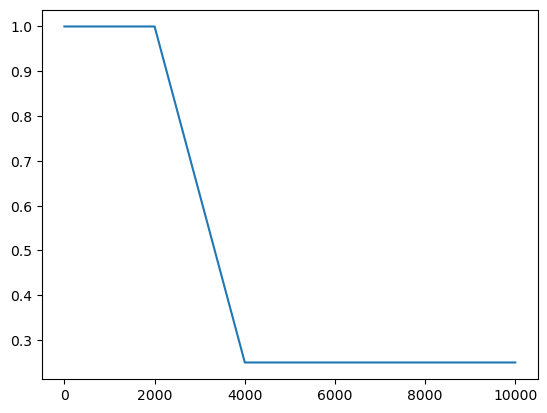

In [82]:
print(schedule.shape)
plt.plot(schedule)

In [86]:
train_loss = train_source(
    data=xo_stats_norm,  # note that we are passing standardized x-s to fit the source
    source_model=source,
    simulator=surrogate,
    optimizer=optimizer,
    entro_dist=None,
    entro_lambda=schedule,
    wasser_p=cfg.source.wasserstein_order,
    wasser_np=cfg.source.wasserstein_slices,
    use_log_sw=cfg.source.use_log_sw,
    num_chunks=cfg.source.num_chunks,
    epochs=cfg.source.pretraining_steps
    + cfg.source.linear_decay_steps
    + cfg.source.lambda_steps,
    min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
    early_stopping_patience=cfg.source.early_stopping_patience,
    device=device,
    print_every=1000,
)

Epoch x Chunk: 0, Weighted Loss: 15.92352000389072, Entropy loss: 15.92352000389072, Wasser loss: -0.21285200119018555
Epoch x Chunk: 1000, Weighted Loss: 0.40608540119751524, Entropy loss: 0.40608540119751524, Wasser loss: -1.4267079830169678
Epoch x Chunk: 2000, Weighted Loss: 0.11661098260060143, Entropy loss: 0.11661098260060143, Wasser loss: -1.3161072731018066
Epoch x Chunk: 3000, Weighted Loss: -1.568471175274764, Entropy loss: 0.006085343667788123, Wasser loss: -4.1906328201293945
Epoch x Chunk: 4000, Weighted Loss: -3.3670030060137615, Entropy loss: 0.11709768663831355, Wasser loss: -4.528369903564453
Epoch x Chunk: 5000, Weighted Loss: -3.5246545200174997, Entropy loss: 0.20060105139972784, Wasser loss: -4.766406536102295
Epoch x Chunk: 6000, Weighted Loss: -3.5699515710012752, Entropy loss: 0.28787026018435213, Wasser loss: -4.855892181396484
Epoch x Chunk: 7000, Weighted Loss: -3.4606168199217566, Entropy loss: 0.2375211999272313, Wasser loss: -4.693329334259033
Epoch x Chu

In [82]:
# train_loss = train_source(
#     data=xo_stats_norm,  # note that we are passing standardized x-s to fit the source
#     source_model=source,
#     simulator=surrogate,
#     optimizer=optimizer,
#     entro_dist=None,
#     entro_lambda=schedule,
#     wasser_p=cfg.source.wasserstein_order,
#     wasser_np=cfg.source.wasserstein_slices,
#     use_log_sw=cfg.source.use_log_sw,
#     num_chunks=cfg.source.num_chunks,
#     epochs=cfg.source.pretraining_steps
#     + cfg.source.linear_decay_steps
#     + cfg.source.lambda_steps,
#     min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
#     early_stopping_patience=cfg.source.early_stopping_patience,
#     device=device,
#     print_every=1000,
# )

Epoch x Chunk: 0, Weighted Loss: 16.071644129656285, Entropy loss: 16.071644129656285, Wasser loss: -0.24544155597686768
Epoch x Chunk: 1000, Weighted Loss: 0.3069252798089881, Entropy loss: 0.3069252798089881, Wasser loss: -1.289235234260559
Epoch x Chunk: 2000, Weighted Loss: 0.2248444992788574, Entropy loss: 0.2248444992788574, Wasser loss: -1.196767807006836
Epoch x Chunk: 3000, Weighted Loss: -1.3481002261581718, Entropy loss: 0.2314668409580225, Wasser loss: -3.9786059856414795
Epoch x Chunk: 4000, Weighted Loss: -3.372085236321894, Entropy loss: 0.17012348647512, Wasser loss: -4.552821636199951
Epoch x Chunk: 5000, Weighted Loss: -3.512997114598309, Entropy loss: 0.26559271836457654, Wasser loss: -4.77252721786499
Epoch x Chunk: 6000, Weighted Loss: -3.5685924043973243, Entropy loss: 0.25160847078960913, Wasser loss: -4.8419928550720215
Epoch x Chunk: 7000, Weighted Loss: -3.4962710557990437, Entropy loss: 0.24568684156212584, Wasser loss: -4.743590354919434
Epoch x Chunk: 8000,

In [87]:
number_of_sims_source

250000

In [88]:
save_state_dict(
    source,
    f"{cfg.base.tag}_learned_source_{number_of_sims_source}.pt",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

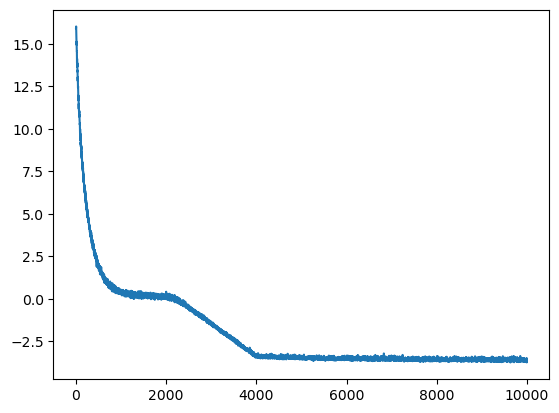

In [89]:
plt.plot(train_loss)
plt.show()

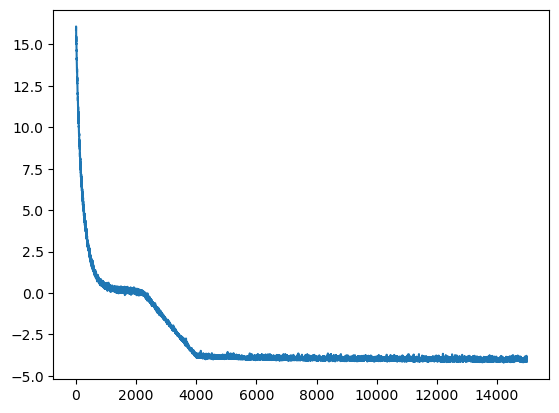

In [100]:
# old run
plt.plot(train_loss)
plt.show()

## source metrics

In [90]:
params.shape

torch.Size([14999995, 13])

In [91]:
source_dim=13

# Evaluate trained source model
with torch.no_grad():
    estimated_source = source.sample(10_000) # so we are assumung the source generates thetas in [-1, 1], because it is trained on standardized x-s
    moved_estimated_source = scale_tensor(   # then move it to the actual range if we wish to pass it through the simulator
        estimated_source.cpu(),
        -torch.ones(source_dim),
        torch.ones(source_dim),
        PRIOR_MIN,
        PRIOR_MAX,
    )
    surro_estimated_pf = surrogate.sample(10_000, estimated_source) # surrogate expects normalized source, standardized x-s
    
# here we need nearest neighbours!!!
# simu_estimated_pf = simulator.sample(moved_estimated_source)

In [92]:
params, estimated_source

(tensor([[ 0.7847, -0.4827,  0.5653,  ...,  0.2637, -0.8465,  0.3477],
         [-0.9305,  0.1965, -0.1808,  ..., -0.6925, -0.9380,  0.8117],
         [-0.8324,  0.5970, -0.8636,  ..., -0.1238, -0.4045,  0.2523],
         ...,
         [-0.2127,  0.3745,  0.2680,  ...,  0.6941, -0.1007,  0.0597],
         [ 0.1593, -0.1530, -0.3240,  ...,  0.9808,  0.4618,  0.2155],
         [-0.3169, -0.7861, -0.5055,  ..., -0.1901, -0.3730, -0.2993]]),
 tensor([[ 0.3937, -0.8400, -0.4073,  ..., -0.4392,  0.1066, -0.2068],
         [ 0.9612,  0.9727, -0.6459,  ...,  0.3485,  0.1846,  0.6904],
         [ 0.3895,  0.9205,  0.6251,  ..., -0.3064,  0.6671, -0.8656],
         ...,
         [-0.9747,  0.7011,  0.8509,  ...,  0.4545,  0.8085, -0.9298],
         [ 0.9320,  0.8966,  0.3111,  ...,  0.4894, -0.1540,  0.3214],
         [ 0.6627,  0.8983, -0.5785,  ...,  0.7472, -0.0707, -0.0058]],
        device='cuda:0'))

In [93]:
((params - estimated_source.cpu()[1])**2).sum(1).min(), ((params - estimated_source.cpu()[1])**2).sum(1).argmin()

(tensor(0.3215), tensor(3316409))

In [94]:
params[((params - estimated_source.cpu()[1])**2).sum(1).argmin().item()]

tensor([ 0.7870,  0.6512, -0.6356,  0.1184, -0.8080, -0.2930, -0.8550, -0.3977,
        -0.2814, -0.4341,  0.5276, -0.0977,  0.7311])

In [95]:
estimated_source[1]

tensor([ 0.9612,  0.9727, -0.6459, -0.0032, -0.7000, -0.3646, -0.7874, -0.3291,
        -0.1280, -0.5336,  0.3485,  0.1846,  0.6904], device='cuda:0')

In [96]:
# source metrics in terms of pushforwards: Classifier two sample tests
# simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu())) # both standardized
print(f"y c2st AUC on surrogate: {surro_c2st}")

y c2st AUC on surrogate: 0.6049


In [73]:
# source metrics in terms of pushforwards: Classifier two sample tests
# simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
print(f"y c2st AUC on surrogate: {surro_c2st}")

y c2st AUC on surrogate: 0.6159


## simu estimated pf using nearest neighbours

In [97]:
params.shape, estimated_source.shape

(torch.Size([14999995, 13]), torch.Size([10000, 13]))

In [98]:
params_gpu = params.to(device)

In [99]:
nns_idx = torch.zeros(estimated_source.shape[0])
for i, test_theta in enumerate(estimated_source):
    test = test_theta.unsqueeze(0)
    #print(test.shape)
    dist = torch.norm(params_gpu - test, dim=1, p=2)
    #print(dist.shape)
    nns_idx[i] = dist.argmin().item()
    # print(i)

In [100]:
# dist2 = torch.norm(params_gpu.unsqueeze(1) - test_batch.unsqueeze(0), dim=2, p=None)

In [101]:
params[nns_idx.long()]

tensor([[ 0.3728, -0.5665, -0.2137,  ..., -0.6072,  0.0506, -0.4395],
        [ 0.7870,  0.6512, -0.6356,  ...,  0.5276, -0.0977,  0.7311],
        [ 0.6077,  0.8963,  0.6606,  ..., -0.5895,  0.8999, -0.8139],
        ...,
        [-0.7912,  0.6332,  0.7086,  ...,  0.6984,  0.9382, -0.8265],
        [ 0.9340,  0.8565,  0.6612,  ...,  0.4607, -0.4091,  0.1750],
        [ 0.7622,  0.7448, -0.6827,  ...,  0.8951, -0.3219, -0.0323]])

In [102]:
estimated_source

tensor([[ 0.3937, -0.8400, -0.4073,  ..., -0.4392,  0.1066, -0.2068],
        [ 0.9612,  0.9727, -0.6459,  ...,  0.3485,  0.1846,  0.6904],
        [ 0.3895,  0.9205,  0.6251,  ..., -0.3064,  0.6671, -0.8656],
        ...,
        [-0.9747,  0.7011,  0.8509,  ...,  0.4545,  0.8085, -0.9298],
        [ 0.9320,  0.8966,  0.3111,  ...,  0.4894, -0.1540,  0.3214],
        [ 0.6627,  0.8983, -0.5785,  ...,  0.7472, -0.0707, -0.0058]],
       device='cuda:0')

In [103]:
xs.mean(0), xs.std(0)

(tensor([ 1.0939e-07,  8.1143e-07,  1.2818e-07,  7.9806e-08, -7.6172e-09]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

In [104]:
nns_estimated_pf = xs[nns_idx.long()]
nns_c2st = np.mean(c2st_scores(nns_estimated_pf.cpu(), gt_simulator_two.cpu()))
print(f"y c2st AUC (NNS estimate): {nns_c2st}")

y c2st AUC (NNS estimate): 0.5772999999999999


- `xo_stats_norm` (created for source training) and `xs` (created during surrogate) are almost same (difference only in the normalization factors), and also ~4M samples were removed from `xo_stats` so that might be the difference!

In [105]:
xo_stats_norm[0:20]

tensor([[ 4.5225e-01, -1.6766e+00, -9.0508e-01,  4.1605e-01,  3.1534e-01],
        [ 5.4062e-01,  1.9547e-01, -1.1837e+00,  1.3039e+00,  4.1660e-01],
        [ 1.7444e+00, -2.4102e-01,  1.2187e-01,  2.7385e+00,  1.8178e-01],
        [ 8.2285e-01,  2.0326e-01, -8.9096e-01,  2.7701e-01,  5.9479e-01],
        [ 3.9167e-02, -1.6128e+00, -1.0011e+00, -4.1628e-01,  5.4116e-01],
        [ 1.1215e-01,  7.7580e-01,  4.1863e-01, -3.1860e-02,  4.2186e-01],
        [ 4.5225e-01,  9.9213e-01,  9.4050e-01,  7.4561e-01,  2.6435e-01],
        [ 6.2057e-01,  1.0035e+00,  3.9325e-02,  2.3825e-01,  3.8622e-01],
        [-8.0935e-01, -1.8211e+00,  1.2019e+00, -6.2083e-01, -1.4936e+00],
        [ 1.1427e+00,  8.6698e-03, -6.9912e-01,  2.0381e+00,  4.4661e-01],
        [-6.2218e-01, -1.3429e+00, -3.1231e-03, -7.6008e-01, -1.1376e+00],
        [ 6.5785e-01,  1.1610e+00, -6.3304e-01,  8.9965e-01,  5.6670e-01],
        [ 1.0566e+00, -1.2566e+00, -4.6464e-01,  1.3542e+00,  3.5937e-01],
        [ 6.9355e-01,  1.

In [106]:
xs[0:20]

tensor([[ 0.4520, -1.6786, -0.9060,  0.4151,  0.3148],
        [ 0.5403,  0.1940, -1.1845,  1.3025,  0.4161],
        [ 1.7440, -0.2426,  0.1206,  2.7364,  0.1811],
        [ 0.8226,  0.2018, -0.8919,  0.2761,  0.5944],
        [-1.0509, -1.1855, -1.9823, -0.8835, -0.9799],
        [ 0.0389, -1.6147, -1.0020, -0.4168,  0.5407],
        [ 0.1119,  0.7745,  0.4172, -0.0326,  0.4213],
        [ 0.4520,  0.9908,  0.9389,  0.7445,  0.2637],
        [ 0.6203,  1.0022,  0.0381,  0.2374,  0.3857],
        [-0.8096, -1.8231,  1.2003, -0.6213, -1.4951],
        [ 1.1424,  0.0071, -0.7001,  2.0364,  0.4461],
        [-0.6225, -1.3448, -0.0044, -0.7605, -1.1389],
        [-1.0509, -1.2026,  0.9852, -0.8184, -1.2368],
        [ 0.6576,  1.1598, -0.6341,  0.8984,  0.5662],
        [-1.0509,  0.2749, -1.1601, -0.9261, -2.4890],
        [ 1.0563, -1.2585, -0.4657,  1.3527,  0.3588],
        [ 0.6933,  1.1288, -0.0438,  0.1700,  0.6282],
        [-1.0509,  0.6731, -0.4968, -0.9177, -1.6606],
        [-

## simu estimated pf using actual simulator

In [107]:
simu_box_pf = M1_model.simulation_wrapper(moved_estimated_source) # here we need to pass unnormalized source!!!
simu_box_pf_np = simu_box_pf.numpy()

strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]
def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
print(np.sum(def_keeping_box))
def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)

simu_estimated_pf = def_stats_box_np

def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1)) # count of non-nan elements
print(np.sum(def_keeping_box))

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:39: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-steepness * (x - offset)))
 [py.warnings]
  return 1 / (1 + np.exp(-steepness * (x - offset)))



9681
10000


In [108]:
simu_estimated_pf = torch.from_numpy(np.float32(simu_estimated_pf))
simu_estimated_pf = (simu_estimated_pf - supervised_mean) / supervised_std
simu_c2st = np.mean(c2st_scores(simu_estimated_pf, gt_simulator_two.cpu()))
print(f"y c2st AUC (simu): {simu_c2st}")

y c2st AUC (simu): 0.7941


In [153]:
gt_simulator_two

tensor([[-0.2282, -0.7599, -0.4519, -0.0781,  0.3782],
        [ 0.4520,  0.6775, -0.1385, -0.3169,  0.6454],
        [ 0.6933,  0.3362, -0.6025,  0.1471,  0.4180],
        ...,
        [ 0.1790, -0.1804, -0.0269,  0.4212,  0.5478],
        [-0.8096, -1.1881, -0.8838, -0.6213,  0.6000],
        [ 1.4893,  0.5672, -0.9352,  1.0117,  0.3203]])

In [102]:
# gt_simulator_two = xo_stats[number_of_sims_source+10_000:number_of_sims_source+20_000, :] # 10k x-s outside those used to train the source

In [99]:
simu_estimated_pf.shape, gt_simulator_two.shape

((10000, 5), torch.Size([10000, 5]))

In [78]:
gt_simulator_two = xo_stats[1_000_000+20_000:1_000_000+30_000, :]

In [79]:
gt_simulator_two.min(), simu_estimated_pf.min(), gt_simulator_two.max(), simu_estimated_pf.max()

(tensor(-130.0352),
 np.float64(-129.91422054894548),
 tensor(2050.7131),
 np.float64(2071.544945753342))

In [81]:
simu_c2st = np.mean(
    c2st_scores(
        torch.from_numpy(simu_estimated_pf),
        gt_simulator_two,#*supervised_std + supervised_mean,
        seed=10,
    )
)
print(f"y c2st AUC on simulator: {simu_c2st}")

y c2st AUC on simulator: 0.5530999999999999


In [117]:
simu_c2st = np.mean(
    c2st_scores(
        torch.from_numpy(simu_estimated_pf),
        gt_simulator_two,
        seed=10,
    )
)
print(f"y c2st AUC on simulator: {simu_c2st}")

y c2st AUC on simulator: 0.53515


In [107]:
gt_simulator_two.device

device(type='cpu')

In [72]:
# swd computation
num_repeat = 1
simu_dists = np.zeros(num_repeat)
for idx in range(10):
    with torch.no_grad():
        # pushforward from simulator on a new & different θ from estimated source
        estimated_source = source.sample(10_000)
        moved_estimated_source = scale_tensor(
            estimated_source.cpu(),
            -torch.ones(source_dim),
            torch.ones(source_dim),
            PRIOR_MIN,
            PRIOR_MAX,
        )
        simu_box_pf = M1_model.simulation_wrapper(moved_estimated_source) # here we need to pass un-normalized source!!!
        simu_box_pf_np = simu_box_pf.numpy()
        strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
        def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]
        def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
        # print(np.sum(def_keeping_box))
        def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
        
        simu_estimated_pf_add = def_stats_box_np
        #simu_est_pf_add = simulator.sample(source.sample(cfg.source.num_eval_obs))
    
    simu_dists[idx] = sliced_wasserstein_distance(
        torch.from_numpy(simu_estimated_pf_add),   # pushforward from simulator using estimated θ
        gt_simulator_two,  # pushforward from simulator using ground truth θ
        num_projections=4096,
        device=device,
    )
simu_swd, simu_swd_std = np.mean(simu_dists), np.std(simu_dists)
print(simu_swd, simu_swd_std)

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:556: RuntimeWarning: divide by zero encountered in log
  np.log(cv),
 [py.warnings]
  np.log(cv),



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [110]:
# print("Estimate source entropies")
estimated_source_kole = kozachenko_leonenko_estimator(estimated_source, on_torus=False).item()
print(f"Estimated source entropy estimate: {estimated_source_kole}")

Estimated source entropy estimate: 8.894167797691697


## source visualization

In [111]:
xo_stats_np.shape, simu_estimated_pf.shape, gt_simulator_two.shape

((11303553, 5), (10000, 5), torch.Size([10000, 5]))

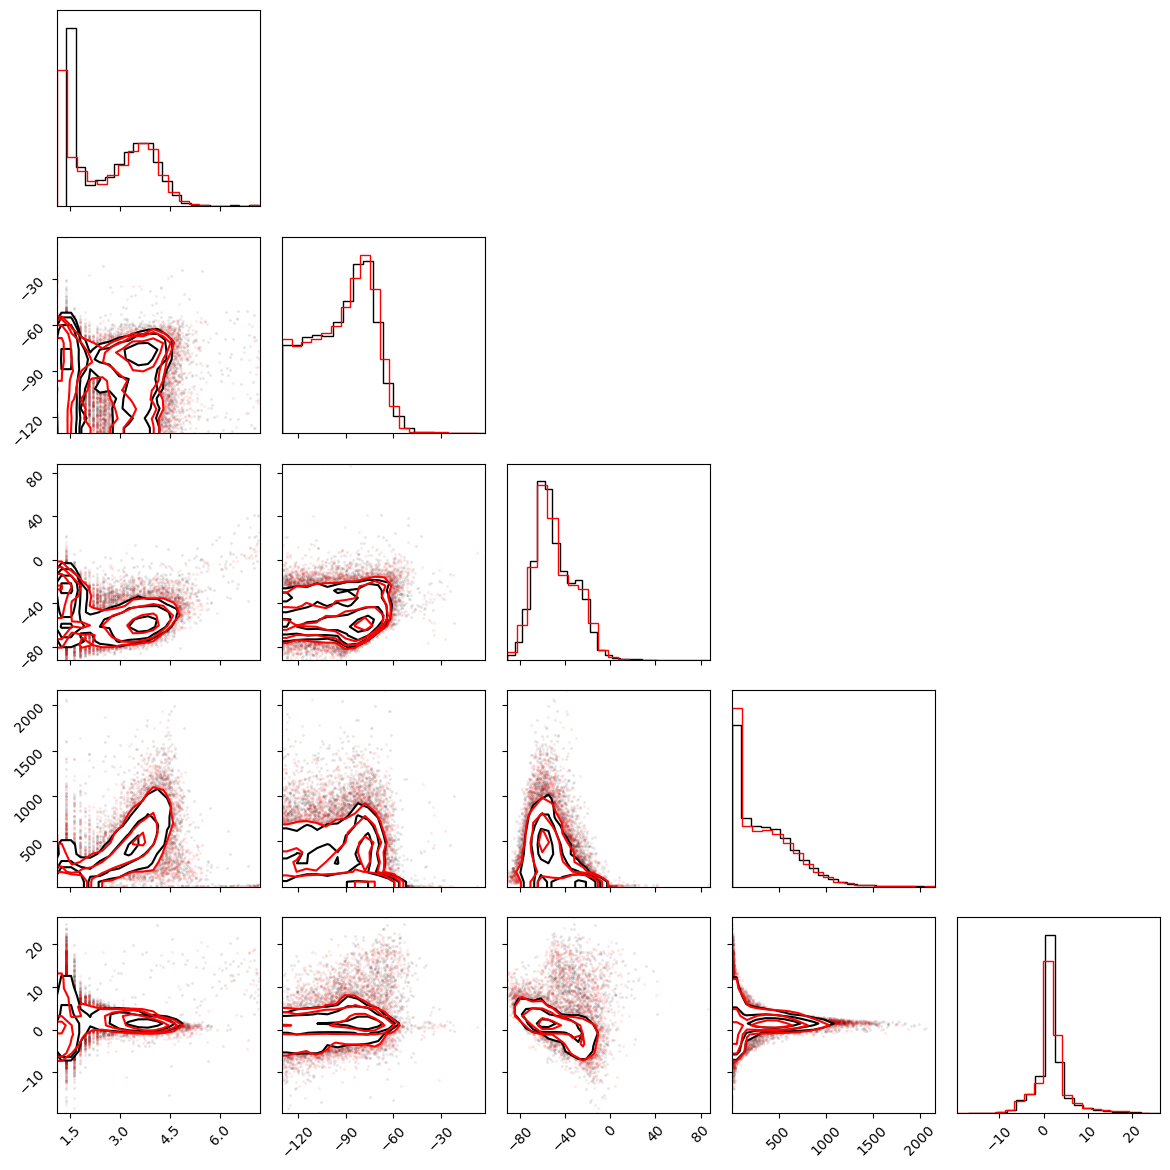

In [112]:
# Plot data with simulator pushforward
fig_simu = corner(
    gt_simulator_two.numpy(),
    color="black",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)
corner(
    simu_estimated_pf,
    fig=fig_simu,
    color="red",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)

save_fig(
    fig_simu,
    file_name=f"{cfg.base.tag}_simulator_fig.pdf",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

In [113]:
# Evaluate trained source model
with torch.no_grad():
    estimated_source = source.sample(10_000)
    moved_estimated_source = scale_tensor(
        estimated_source.cpu(),
        -torch.ones(source_dim),
        torch.ones(source_dim),
        PRIOR_MIN,
        PRIOR_MAX,
    )
moved_estimated_source

tensor([[ 1.3936e+01,  8.0737e+02,  3.3308e+01,  ...,  3.3929e+03,
         -8.2402e+01,  9.3922e-01],
        [ 5.8261e+00,  5.7269e+02,  6.3948e+01,  ...,  3.4586e+03,
         -7.4906e+01,  4.5200e-01],
        [ 7.8429e+00,  7.7978e+02,  5.6335e+01,  ...,  3.4541e+03,
         -7.3443e+01,  2.8389e+00],
        ...,
        [ 2.6415e+00,  9.0689e+02,  2.4322e+01,  ...,  1.0331e+02,
         -4.2254e+01,  2.8071e+00],
        [ 2.7489e+00,  9.9534e+02,  3.2809e+01,  ...,  1.7346e+03,
         -8.7135e+01,  2.6183e+00],
        [ 1.1984e+00,  5.8140e+02,  5.3761e+01,  ...,  3.2500e+02,
         -7.2071e+01,  2.3111e+00]])

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
6 4
7 0
7 1
7 2
7 3
7 4


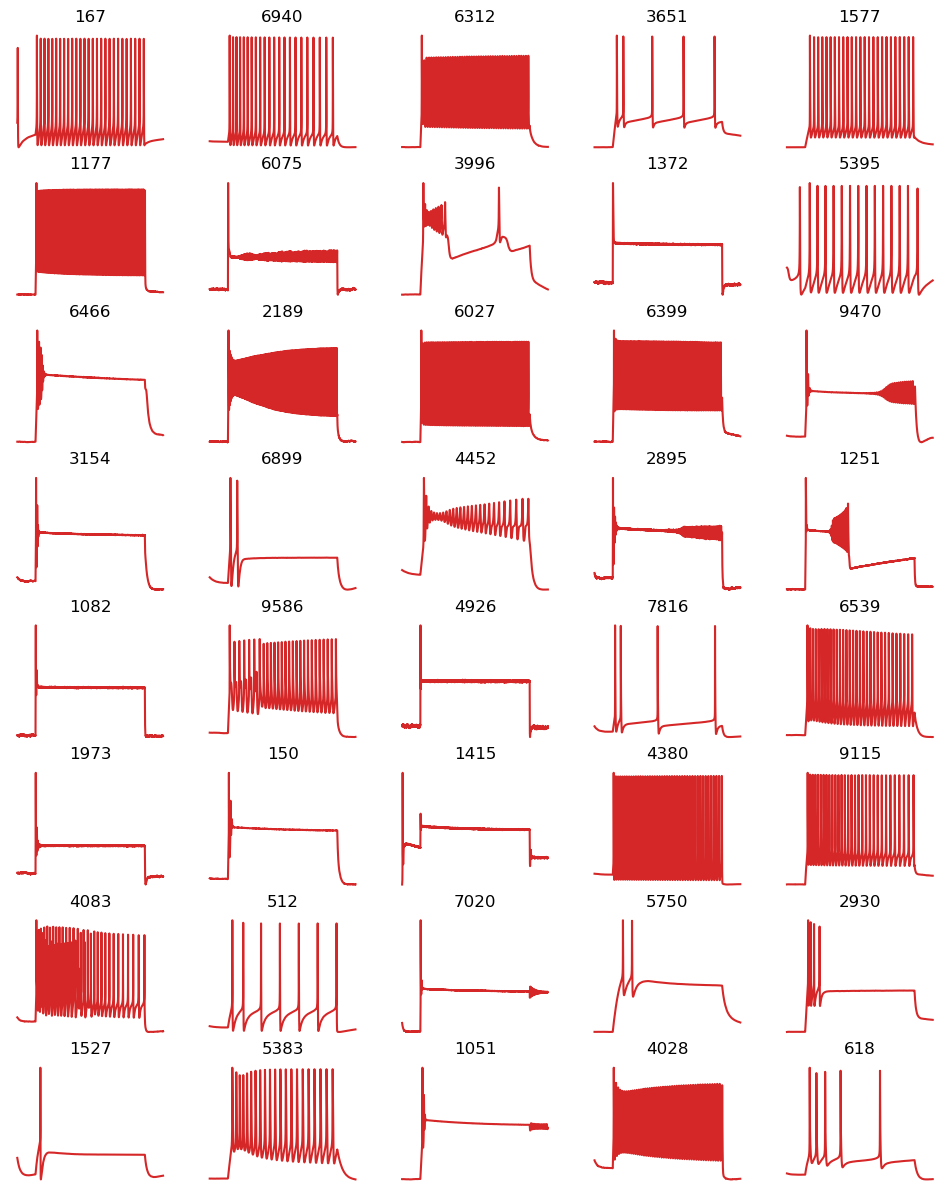

In [82]:
# Plot some traces from simulator pushforward of learned source
fig_samp_source, axs = plt.subplots(8, 5, figsize=(12, 15))
for i in range(8):
    for j in range(5):
        print(i, j)
        rand = np.random.randint(moved_estimated_source.shape[0])
        trial = moved_estimated_source[rand][np.newaxis, :]
        x = M1_model.run_HH_model(trial)
        axs[i, j].plot(x["time"], x["data"][0, 0, :], c="C3")
        axs[i, j].set_title(rand)
        axs[i, j].set_axis_off()

plt.show()

0
1
2
3
4
5
6
7


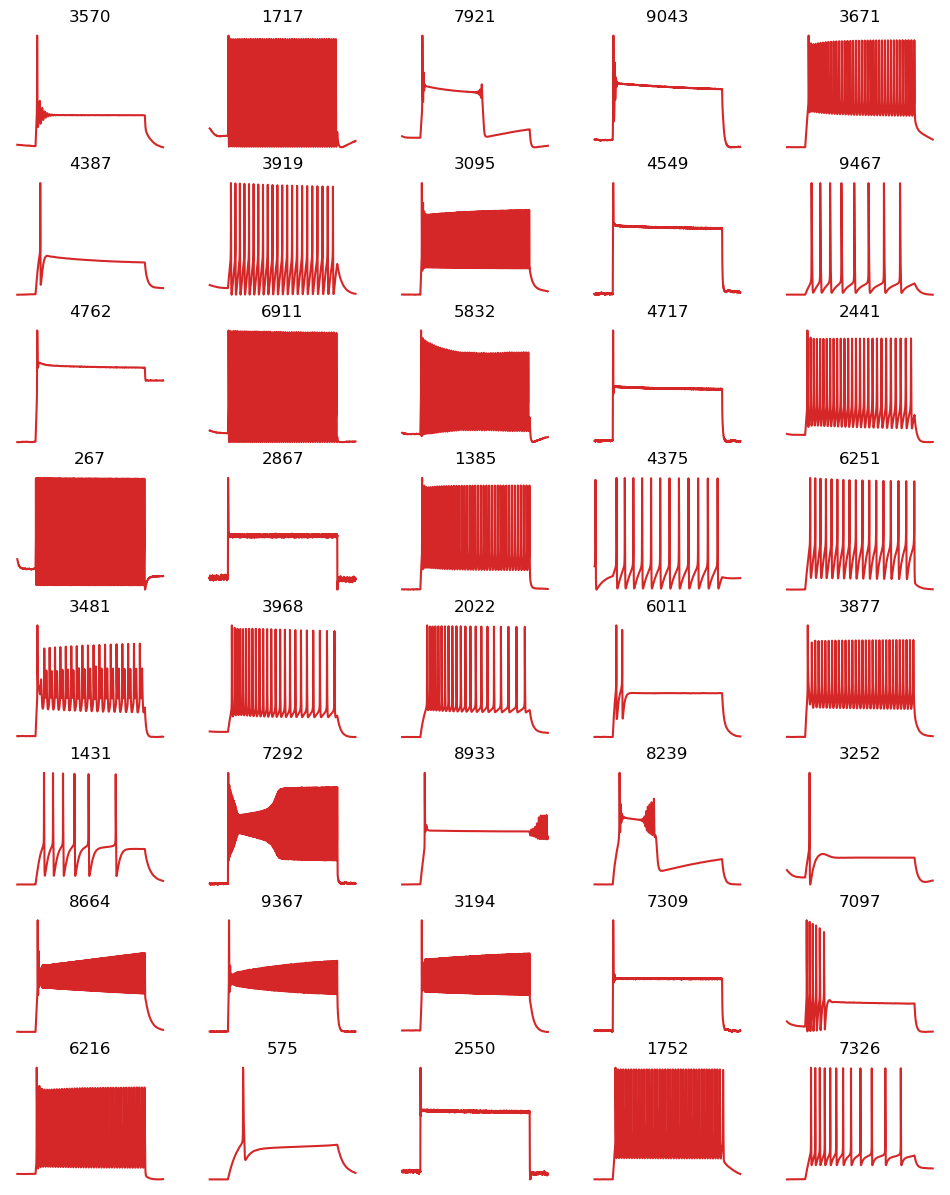

In [114]:
# Plot some traces from simulator pushforward of learned source
fig_samp_source, axs = plt.subplots(8, 5, figsize=(12, 15))
for i in range(8):
    print(i)
    for j in range(5):
        rand = np.random.randint(moved_estimated_source.shape[0])
        trial = moved_estimated_source[rand][np.newaxis, :]
        x = M1_model.run_HH_model(trial)
        axs[i, j].plot(x["time"], x["data"][0, 0, :], c="C3")
        axs[i, j].set_title(rand)
        axs[i, j].set_axis_off()

plt.show()



save_fig(
    fig_samp_source,
    file_name=f"{cfg.base.tag}_samp_source_fig_{number_of_sims_source}.pdf",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

In [123]:
print(PRIOR_MIN)
print(PRIOR_MAX)

tensor([ 1.0000e-01,  2.0000e+01,  1.0000e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3000e+02,
         5.0000e+01, -9.0000e+01,  1.0000e-01])
tensor([  15, 1000,   70,  250,  100,   30,    3,  250,    3,  -50, 4000,  -35,
           3])


In [124]:
# Plot some traces from simulated pushforward of reference box prior
num_xo = 10_000
prior = VariableTemperedUniform(lower_bound=PRIOR_MIN, upper_bound=PRIOR_MAX)
prior_samples = prior.sample(num_xo) # these are unnormalized

simu_box_pf = M1_model.simulation_wrapper(prior_samples)

# %%
# same procedure as above (this is a bit messy)
simu_box_pf_np = simu_box_pf.numpy()

strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
print(np.sum(strict_keeping_box))

def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]

def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
print(np.sum(def_keeping_box))
def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
print(np.sum(def_keeping_box))

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:552: RuntimeWarning: invalid value encountered in log
  np.log(AP_amp_adapt),
 [py.warnings]
  np.log(AP_amp_adapt),

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:556: RuntimeWarning: divide by zero encountered in log
  np.log(cv),
 [py.warnings]
  np.log(cv),



4781
7560
10000


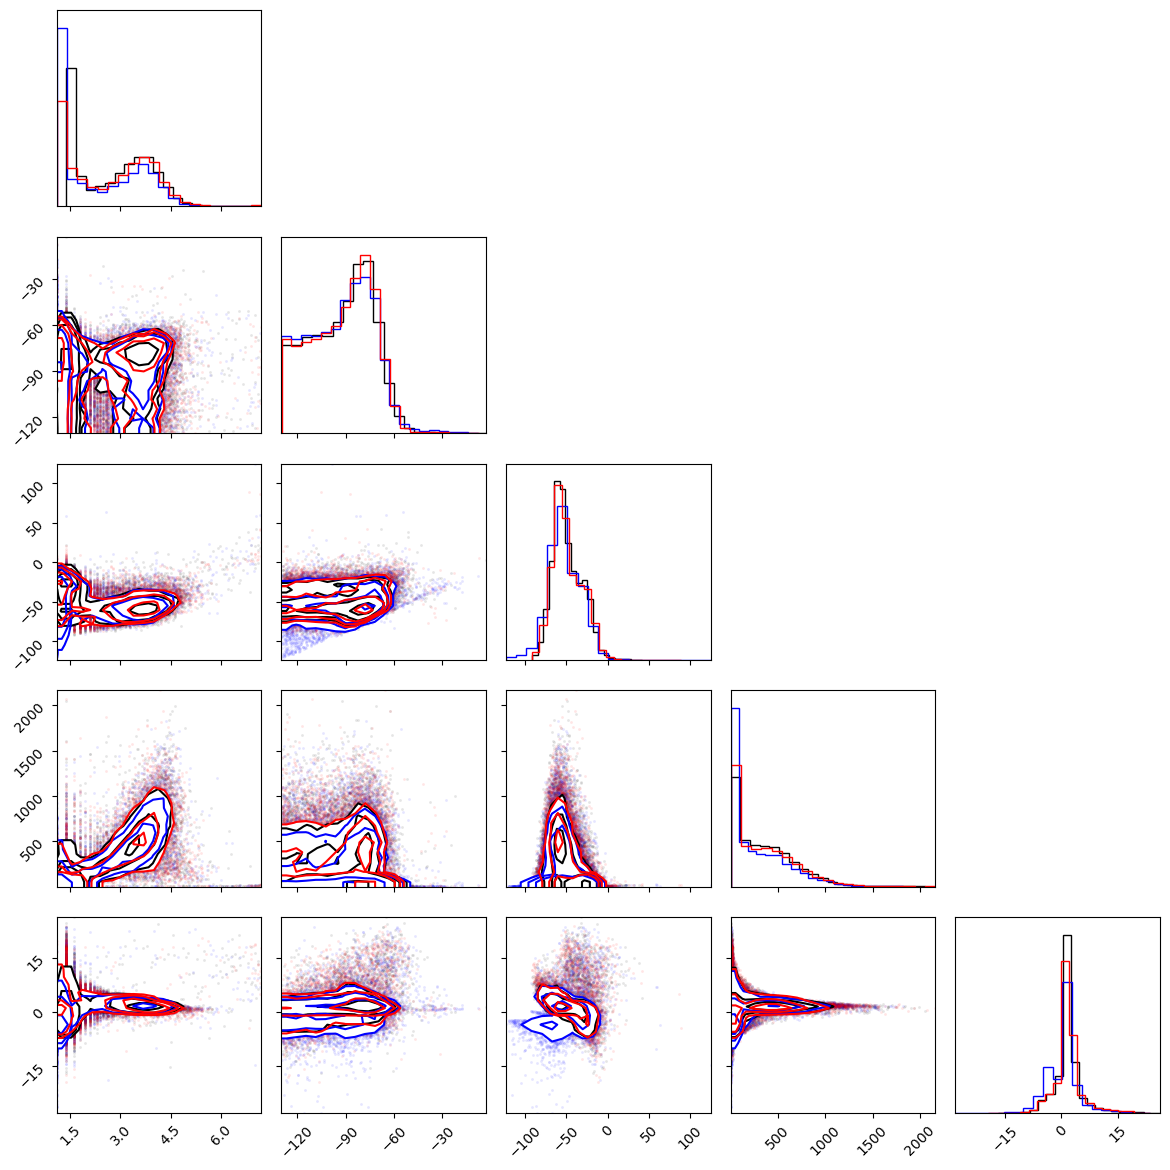

In [125]:
# %%
fig_simu_extend = corner(
    gt_simulator_two.numpy(),
    color="black",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)
corner(
    def_stats_box_np,
    fig=fig_simu_extend,
    color="blue",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)
corner(
    simu_estimated_pf,
    fig=fig_simu_extend,
    color="red",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)

save_fig(
    fig_simu_extend,
    file_name=f"{cfg.base.tag}_simulator_extended_fig.pdf",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

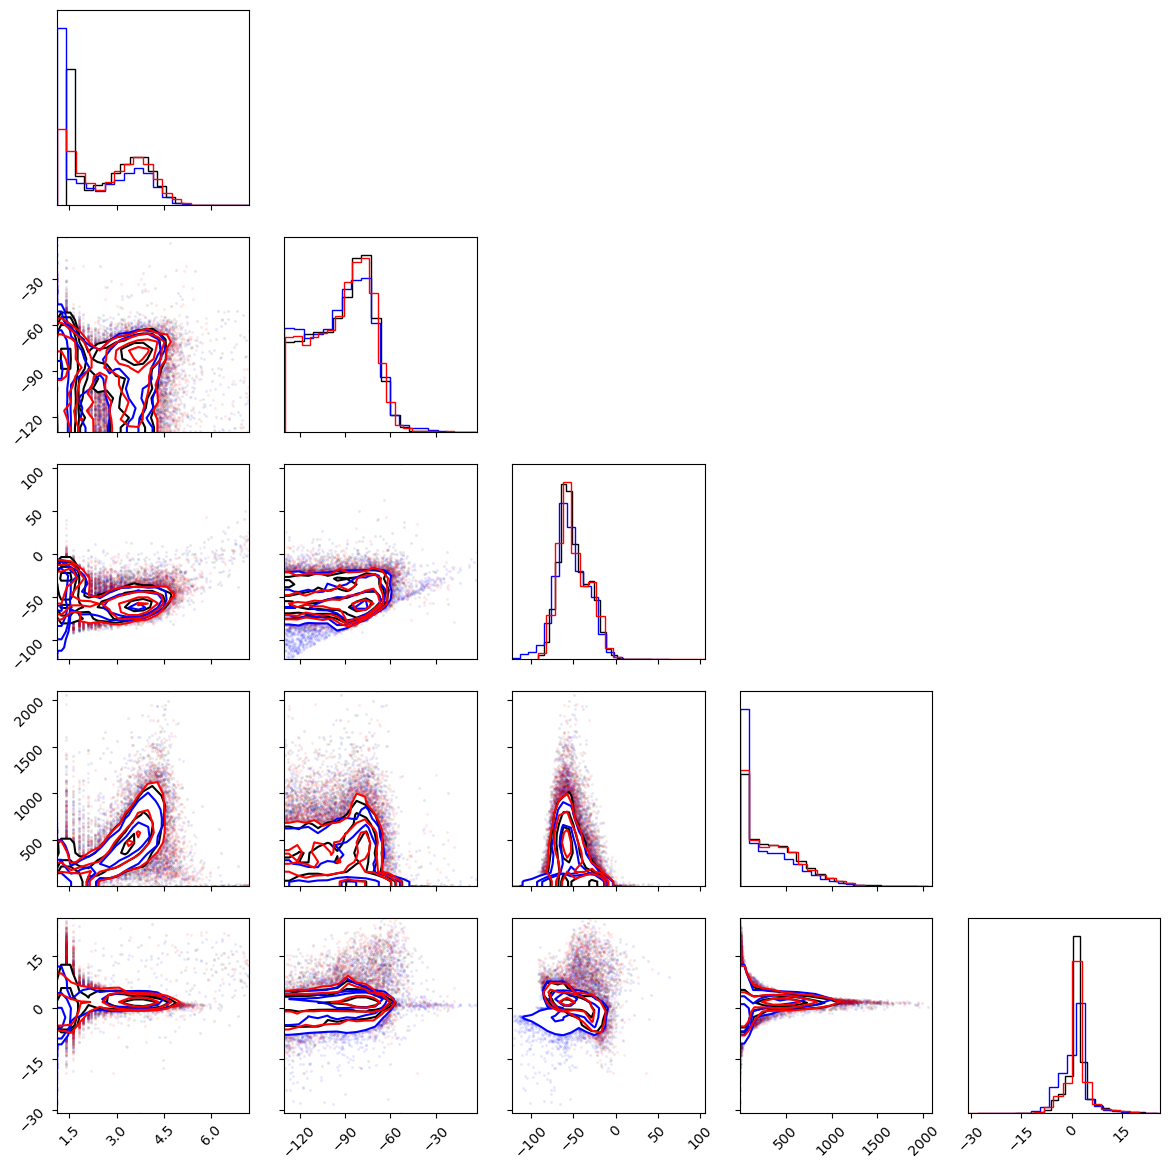

In [85]:
# %%
fig_simu_extend = corner(
    gt_simulator_two.numpy(),
    color="black",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)
corner(
    def_stats_box_np,
    fig=fig_simu_extend,
    color="blue",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)
corner(
    simu_estimated_pf,
    fig=fig_simu_extend,
    color="red",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)

save_fig(
    fig_simu_extend,
    file_name=f"{cfg.base.tag}_simulator_extended_fig.pdf",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

In [89]:
source

Sampler(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=13, bias=True)
  )
)

In [99]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Jan 13 11:40:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:81:00.0 Off |                    0 |
| N/A   30C    P0              45W / 250W |   1283MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [155]:
# del xo_stats_norm